## Installing neccessary libraries and mounting dataset to runtime (note: attach kaggle.json file)

In [1]:
!pip install torch-geometric -f https://data.pyg.org/whl/torch-1.9.0+cu111.html

Looking in links: https://data.pyg.org/whl/torch-1.9.0+cu111.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.0 MB/s eta 0:00:00


In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files

# Upload kaggle.json
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sujalpore47","key":"79476bd6e928ad56b60e49fe8c750412"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d prathumarikeri/indian-sign-language-isl

 96% 269M/281M [00:02<00:00, 130MB/s]
100% 281M/281M [00:02<00:00, 110MB/s]


In [6]:
!unzip -q /content/indian-sign-language-isl.zip -d /content/dataset

#With cnn based approach

## Importing libraries,loading dataset , processing data , creating , saving and evaluating models.

In [ ]:
!pip install -U git+https://github.com/stellargraph/stellargraph.git



In [ ]:
#Importing Libraries
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import networkx as nx
import pickle
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score, classification_report

# Step 1: Preprocessing and Segmentation
def preprocess_image(image):
    resized_image = cv2.resize(image, (128, 128))  # Resize the image to a fixed size
    gray_img = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    # Convert grayscale to 3-channel image
    rgb_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)
    return rgb_img

# Step 1: Node and Edge Creation
def create_graph(image):
    G = nx.grid_2d_graph(*image.shape)
    return G

# Step 2: Define the GCN model
def create_model(input_shape, num_classes):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Step 3: Train the model
def train_model(train_generator, val_generator, num_classes):
    model = create_model(train_generator.image_shape, num_classes)

    # Use fit_generator for training with data generator
    model.fit_generator(
        train_generator,
        validation_data=val_generator,
        epochs=5,
        verbose=1,
        steps_per_epoch=len(train_generator),
        validation_steps=len(val_generator)
    )

    return model

# Function to save the trained model
def save_model(model, class_name):
    os.makedirs('/content/saved_models1', exist_ok=True)
    location = os.path.join("/content/saved_models1", class_name)
    model.save(location, save_traces=False)

# Function to save graphs
def save_graphs(graphs, class_names, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for class_name, class_graphs in zip(class_names, graphs):
        class_dir = os.path.join(save_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)
        for i, graph in enumerate(class_graphs):
            with open(os.path.join(class_dir, f"graph_{i}.gpickle"), 'wb') as f:
                pickle.dump(graph, f)

# Load dataset and prepare data using ImageDataGenerator
data_dir = "/content/dataset/Indian"
batch_size = 12

# Use ImageDataGenerator for on-the-fly preprocessing and augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_image,
    validation_split=0.9  # Split the data into training and validation
)

# Get the list of classes
class_names = sorted(os.listdir(data_dir))

# Iterate over each subset of classes
subset_size = 35
for i in range(0, len(class_names), subset_size):
    subset_classes = class_names[i:i+subset_size]

    # Load data for the current subset of classes
    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(128, 128),
        batch_size= batch_size,
        class_mode='sparse',
        subset='training',
        shuffle=True,
        seed=42,
        interpolation="nearest",
        follow_links=False,
        classes=subset_classes
    )

    val_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='sparse',
        subset='validation',
        shuffle=True,
        seed=42,
        interpolation="nearest",
        follow_links=False,
        classes=subset_classes
    )

    # Train the model for the current subset of classes
    model = train_model(train_generator, val_generator, num_classes=len(subset_classes))

    # Save the trained model for the current subset of classes
    for class_name in subset_classes:
        save_model(model, class_name)

        # Load a batch of validation images for graph creation
        X_val, _ = next(val_generator)

        # Save the graphs for the current class
        save_graphs([create_graph(image) for image in tqdm(X_val)], [class_name], "/content/saved_graphs1")

In [ ]:
# Function to predict labels using the trained model
def predict_labels(model, generator):
    y_true = []
    y_pred = []

    for _ in range(0,len(generator),100):
        X_batch, y_batch = next(generator)
        y_true.extend(y_batch)
        y_pred.extend(np.argmax(model.predict(X_batch), axis=1))

    return np.array(y_true), np.array(y_pred)

# Function to evaluate the model using F2 score and other metrics
def evaluate_model(model, val_generator):
    y_true, y_pred = predict_labels(model, val_generator)

    f2 = fbeta_score(y_true, y_pred, average='macro', beta=2)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    print("F2 Score:", f2)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

# Evaluate the model
evaluate_model(model, val_generator)

## Prediction Window for multiple images

In [ ]:
#Importing Libraries
import os
import cv2
import numpy as np
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor

In [ ]:
# Specify the class names
class_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

# Load models for each class in parallel
def load_model(class_name):
    saved_model_path = f"/content/saved_models1/{class_name}"
    if os.path.exists(saved_model_path):
        try:
            model = tf.keras.models.load_model(saved_model_path)
            return class_name, model
        except Exception as e:
            print(f"Error loading saved model for class {class_name}: {str(e)}")
    else:
        print(f"No model found for class {class_name}")
    return None, None

# Use ThreadPoolExecutor to load models concurrently
with ThreadPoolExecutor() as executor:
    model_futures = {executor.submit(load_model, class_name): class_name for class_name in class_names}
    models = {class_name: model for future in model_futures for class_name, model in [future.result()]}

# Function to preprocess the input image
def preprocess_image(image):
    if image is None:
        raise ValueError("Unable to load the image.")

    # Resize the image to match the input shape expected by the models
    resized_image = cv2.resize(image, (128, 128))

    # Normalize the pixel values to the range [0, 1]
    normalized_image = resized_image / 255.0

    return normalized_image


In [ ]:
# List of image paths
image_paths = ["/content/dataset/Indian/A/1.jpg", "/content/dataset/Indian/B/2.jpg", "/content/dataset/Indian/1/0.jpg","/content/dataset/Indian/4/1076.jpg"]

# Predict class for each image in the batch
predictions = {}
for image_path in image_paths:
    # Load the input image
    image = cv2.imread(image_path)

    # Preprocess the input image
    preprocessed_image = preprocess_image(image)

    # Perform prediction for each class concurrently and calculate accuracy
    def predict_class(class_name, model):
        try:
            prediction = model.predict(np.expand_dims(preprocessed_image, axis=0))
            predicted_index = np.argmax(prediction, axis=1)[0]
            return class_name, int(predicted_index == class_names.index(class_name))
        except Exception as e:
            print(f"Error predicting for class {class_name} and image {image_path}: {str(e)}")
            return class_name, 0

    # Use ThreadPoolExecutor to predict classes concurrently
    with ThreadPoolExecutor() as executor:
        prediction_futures = {executor.submit(predict_class, class_name, model): class_name for class_name, model in models.items()}
        accuracies = {class_name: accuracy for future in prediction_futures for class_name, accuracy in [future.result()]}

    # Find the class with the highest accuracy for this image
    image_predictions = {class_name: accuracy for class_name, accuracy in accuracies.items()}
    predicted_class = max(image_predictions, key=image_predictions.get)
    predictions[image_path] = predicted_class

# Display predictions for each image
for image_path, predicted_class in predictions.items():
    print(f"Predicted class for image {image_path}: {predicted_class}")


## For single image


In [ ]:
# For single image
import os
import cv2
import numpy as np
import tensorflow as tf

# Specify the class names
class_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

# Load models for each class
models = {}
for class_name in class_names:
    saved_model_path = f"/content/saved_models1/{class_name}"
    if os.path.exists(saved_model_path):
        try:
            models[class_name] = tf.keras.models.load_model(saved_model_path)
        except Exception as e:
            print(f"Error loading saved model for class {class_name}: {str(e)}")
    else:
        print(f"No model found for class {class_name}")

# Function to preprocess the input image
def preprocess_image(image):
    if image is None:
        raise ValueError("Unable to load the image.")

    resized_image = cv2.resize(image, (128, 128))  # Resize the image to a fixed size
    gray_img = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    # Convert grayscale to 3-channel image
    rgb_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)
    return rgb_img

# Load the input image
image_path = "/content/dataset/Indian/A/1.jpg"
image = cv2.imread(image_path)

# Preprocess the input image
preprocessed_image = preprocess_image(image)

# Perform prediction for each class and calculate accuracy
accuracies = {}
max_accuracy = 0
predicted_class = None

for class_name, model in models.items():
    try:
        prediction = model.predict(np.expand_dims(preprocessed_image, axis=0))
        predicted_index = np.argmax(prediction, axis=1)[0]
        accuracy = accuracies.get(class_name, 0)  # Get the current accuracy for this class (default to 0)
        accuracies[class_name] = accuracy + int(predicted_index == class_names.index(class_name))  # Update accuracy

        if accuracies[class_name] > max_accuracy:
            max_accuracy = accuracies[class_name]
            predicted_class = class_name
    except Exception as e:
        print(f"Error predicting for class {class_name}: {str(e)}")

# Display predicted class
print("Predicted class:", predicted_class)


1/1 [==============================] - 0s 51ms/step
Predicted class: A


##With gcn based approach


##Importing libraries and defining functions

In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import functional as TF
from torch_geometric.data import Data, DataLoader, Batch
import pickle
import gc
from torch_geometric.nn import GraphConv, global_max_pool , global_mean_pool , global_add_pool
from sklearn.model_selection import train_test_split
from torch.nn import BatchNorm1d
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
def preprocess_image(image):
    resized_image = cv2.resize(image, (32, 32))
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    return TF.to_tensor(gray_image).unsqueeze(0).detach().to(device)

# Function to release tensors from CUDA and system memory
def free_memory():
    gc.collect()
    torch.cuda.empty_cache()

# Graph creation function
def create_graph(image):
    num_nodes = image.shape[1] * image.shape[2]
    features = image.view(-1, 1)
    edge_index, edge_weight = [], []
    height, width = image.shape[1], image.shape[2]
    # Considering 2D grid neighbors
    for i in range(height):
        for j in range(width):
            if j + 1 < width:
                edge_index.append([i * width + j, i * width + j + 1])
            if i + 1 < height and j + 1 < width:
                edge_index.append([i * width + j, (i + 1) * width + j + 1])
            if i + 1 < height:
                edge_index.append([i * width + j, (i + 1) * width + j])
            if i + 1 < height and j - 1 >= 0:
                edge_index.append([i * width + j, (i + 1) * width + j - 1])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous().to(device)
    return Data(x=features, edge_index=edge_index)

# Function to save class names to ensure consistency
def save_class_names(class_names, save_path="content"):
    os.makedirs(save_path, exist_ok=True)
    with open(os.path.join(save_path, "class_names.pkl"), 'wb') as file:
        pickle.dump(class_names, file)

# Function to load class names to ensure consistency
def load_class_names(load_path="content/class_names.pkl"):
    with open(load_path, 'rb') as file:
        class_names = pickle.load(file)
    return class_names

# Saves a graph object to a specified directory, organized by class names
def save_graph(graph, class_name, file_name, base_dir="content/savegraphs"):
    class_path = os.path.join(base_dir, class_name)
    os.makedirs(class_path, exist_ok=True)  # Ensure the class directory exists
    graph_path = os.path.join(class_path, f"{file_name}.pkl")
    with open(graph_path, 'wb') as file:
        pickle.dump(graph, file)

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir=None, data_list=None, class_names=None, max_memory_gb=10):
        assert data_dir is not None or data_list is not None, "Either data_dir or data_list must be provided"

        self.max_memory_gb = max_memory_gb
        self.data_list = data_list if data_list is not None else []

        if class_names is not None:
            self.class_names = class_names
        else:
            # Ensure class names are read in a predefined order if not provided
            self.class_names = sorted(os.listdir(data_dir))

        self.num_classes = len(self.class_names)
        if data_dir:
            self.data_dir = data_dir
            self.generate_data()

    def generate_data(self):
        # Ensures class names are used in a consistent order for index assignment
        for class_name in self.class_names:
            class_index = self.class_names.index(class_name)
            class_dir = os.path.join(self.data_dir, class_name)

            for file_name in sorted(os.listdir(class_dir)):
                image_path = os.path.join(class_dir, file_name)
                image = cv2.imread(image_path)
                preprocessed_image = preprocess_image(image)
                graph = create_graph(preprocessed_image)
                graph.y = torch.tensor([class_index], dtype=torch.long).to(device)

                # Save the graph here, using the provided function
                save_graph(graph, class_name, os.path.splitext(file_name)[0])

                self.data_list.append(graph)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):
        return self.data_list[index]


class GCNNet(torch.nn.Module):
    def __init__(self, num_classes):
        super(GCNNet, self).__init__()
        self.conv1 = GraphConv(1, 32)
        self.bn1 = BatchNorm1d(32)  # Batch normalization for the output of conv1
        self.conv2 = GraphConv(32, 64)
        self.bn2 = BatchNorm1d(64)  # Batch normalization for the output of conv2
        self.conv3 = GraphConv(64, 128)
        self.bn3 = BatchNorm1d(128)  # Batch normalization for the output of conv3

        self.drop1 = nn.Dropout(p=0.2)
        self.drop2 = nn.Dropout(p=0.4)
        self.drop3 = nn.Dropout(p=0.6)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Apply batch normalization
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)  # Apply batch normalization
        x = F.relu(x)
        x = self.drop1(x)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)  # Apply batch normalization
        x = F.relu(x)
        x = self.drop2(x)

        x = global_max_pool(x, batch)
        x = self.drop3(x)

        x = self.fc(x)

        return F.log_softmax(x, dim=1)



# Training function
def train_model(train_loader, val_loader, model, criterion, optimizer, scheduler, num_epochs, patience=8):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_loss = 0
        for batch_data in train_loader:
            batch_data = batch_data.to(device)
            optimizer.zero_grad()
            output = model(batch_data)
            loss = criterion(output, batch_data.y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Validation step
        avg_val_loss, val_accuracy_percentage = validate_model(model, val_loader, criterion)

        # Print training and validation results for the epoch
        print(f"Epoch {epoch+1}, Training Loss: {epoch_loss / len(train_loader)}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy_percentage}%")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss  # Update the best validation loss
            patience_counter = 0  # Reset the patience counter
        else:
            patience_counter += 1  # Increment the patience counter because the validation loss did not decrease

        # Check if patience has run out
        if patience_counter >= patience:
            print("Early stopping triggered at epoch:", epoch+1)
            break  # Exit from the training loop

        # Step the scheduler
        scheduler.step()

    # Clean up after training
    del batch_data
    free_memory()

    return model



# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for data in val_loader:
        data = data.to(device)
        output = model(data)
        loss = criterion(output, data.y)
        total_loss += loss.item()

        _, predicted = torch.max(output, 1)  # Get the index of the max log-probability as the predicted label
        correct_predictions += (predicted == data.y).sum().item()  # Sum up correct predictions
        total_predictions += data.y.size(0)  # Count total predictions

    avg_loss = total_loss / len(val_loader)
    accuracy_percentage = (correct_predictions / total_predictions) * 100  # Calculate accuracy in percentage

    return avg_loss, accuracy_percentage


# Save model function
def save_model(model, base_dir="content/savemodels"):
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    model_path = os.path.join(base_dir, "model.pth")  # Save model in a common directory
    torch.save(model.state_dict(), model_path)

# Load model function
def load_model(num_classes, base_dir="content/savemodels", model_name="model.pth"):
    model_path = os.path.join(base_dir, model_name)  # Make sure you're loading the correct model file
    model = GCNNet(num_classes)  # Initialize the EnhancedGCNNet instead of GCNNet
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    return model

# Prediction function
def predict_image(image_path, model):
    model.eval()  # Ensures model is in evaluation mode
    image = cv2.imread(image_path)
    preprocessed_image = preprocess_image(image)  # Double-check this step
    graph = create_graph(preprocessed_image)  # Confirm graph creation matches training
    graph = Batch.from_data_list([graph]).to(device)
    with torch.no_grad():
        output = model(graph)
        _, predicted = torch.max(output, 1)
    return predicted.item()

# Function to predict images for multiple
def predict_images(image_paths, model, dataset):
    predicted_classes = []
    model.eval()  # Ensure the model is in evaluation mode
    for image_path in image_paths:
        predicted_index = predict_image(image_path, model)  # Verify individual prediction
        predicted_class_name = dataset.class_names[predicted_index]  # Map index to class
        predicted_classes.append(predicted_class_name)
    return predicted_classes

# Loading the dataset
def load_entire_dataset(load_path="content/dataset/entire_dataset.pkl"):
    with open(load_path, 'rb') as file:
        dataset_loaded = pickle.load(file)

    # Ensure that 'class_names' is loaded correctly and used
    loaded_dataset = CustomDataset(data_list=dataset_loaded['data_list'], class_names=dataset_loaded['class_names'])

    return loaded_dataset

# Saving the dataset
def save_entire_dataset(dataset, save_path="content"):
    # Ensure the save directory exists
    os.makedirs(save_path, exist_ok=True)
    file_path = os.path.join(save_path, "entire_dataset.pkl")  # Define the file path

    dataset_to_save = {
        'data_list': dataset.data_list,
        'class_names': dataset.class_names  # Directly access class_names, assuming it’s always defined
    }

    # Serialize and save the dataset
    with open(file_path, 'wb') as file:
        pickle.dump(dataset_to_save, file)

    print(f"Dataset successfully saved to {file_path}")



##Data Augmentation and saving

In [8]:
# Initialize class names in a predefined order
class_names_ordered = [str(i) for i in range(1, 10)] + [chr(j) for j in range(ord('A'), ord('Z')+1)]

# Define data directory
data_dir = "content/Indian"

# Create dataset and DataLoader
dataset = CustomDataset(data_dir=data_dir)
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2)
train_loader = DataLoader(train_dataset, batch_size=1200, shuffle=True, collate_fn=Batch.from_data_list)
val_loader = DataLoader(val_dataset, batch_size=1200, shuffle=False, collate_fn=Batch.from_data_list)

# Save entire dataset
save_entire_dataset(dataset, "content/dataset")

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset successfully saved to /content/dataset/entire_dataset.pkl


##Initialize model, criterion, optimizer , training and saving it

In [17]:
# Initialize class names in a predefined order
class_names_ordered = [str(i) for i in range(1, 10)] + [chr(j) for j in range(ord('A'), ord('Z')+1)]
# Initialize model, criterion, optimizer
model = GCNNet(num_classes=len(class_names_ordered)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.93)

###Training the model

In [18]:
# Training model and saving it
num_epochs = 100
model = train_model(train_loader, val_loader, model, criterion, optimizer, scheduler, num_epochs=68, patience=8)

# Save the trained model
classname = 'GCN_model'  # Specify the class name/model name you want to use
base_dir = "content/savemodels"  # Specify your base directory for saving model
save_model(model, base_dir ) # Here save_model function will do the job of creating necessary directories and save the model in this path: /content/savemodels/GCN_model/model_GCN_model.pth

# For multiple predictions
image_paths = ["content/Indian/1/10.jpg"] # Add your image paths here
predictions = predict_images(image_paths, model, dataset)
for image_path, prediction in zip(image_paths, predictions):
    print(f"The prediction for {image_path} is class: {prediction} ")

Epoch 1, Training Loss: 7.962296584556842, Validation Loss: 3.5305991172790527, Validation Accuracy: 3.544274184115101%
Epoch 2, Training Loss: 4.384466968733689, Validation Loss: 3.449691116809845, Validation Accuracy: 4.690607088548368%
Epoch 3, Training Loss: 3.6372785650450608, Validation Loss: 3.344175785779953, Validation Accuracy: 3.6378523803953677%
Epoch 4, Training Loss: 3.293985021525416, Validation Loss: 3.1737767159938812, Validation Accuracy: 11.00713533746637%
Epoch 5, Training Loss: 3.0389279743720747, Validation Loss: 2.9779482781887054, Validation Accuracy: 14.387647678091003%
Epoch 6, Training Loss: 2.8038142549580543, Validation Loss: 2.784172296524048, Validation Accuracy: 19.69821031699614%
Epoch 7, Training Loss: 2.6032648415401063, Validation Loss: 2.6268535554409027, Validation Accuracy: 21.265645104690606%
Epoch 8, Training Loss: 2.398968787028872, Validation Loss: 2.444001317024231, Validation Accuracy: 27.02070417592701%
Epoch 9, Training Loss: 2.21440297981

##Prediction window

###Loading the pre-trained model

In [19]:
class_names_ordered = [str(i) for i in range(1, 10)] + [chr(j) for j in range(ord('A'), ord('Z')+1)]
num_classes = len(class_names_ordered)
Dataset = load_entire_dataset(load_path="content/dataset/entire_dataset.pkl")  # Correct variable casing for consistency
# Initialize the model using 'num_classes' calculated from 'class_names_ordered'
model = GCNNet(num_classes=len(class_names_ordered)).to(device) # Adjust to use 'num_classes'
# NOTE: Assuming class_name no longer needed due to class_names_ordered
model = load_model(num_classes=num_classes, base_dir="content/savemodels")

###Predicting image classes for multiple images

In [27]:
# file paths you want to predict
image_paths = ["content/Indian/1/10.jpg","content/Indian/2/0.jpg","content/Indian/3/0.jpg","content/Indian/4/0.jpg","content/Indian/5/0.jpg","content/Indian/6/0.jpg","content/Indian/7/0.jpg","content/Indian/8/0.jpg","content/Indian/9/0.jpg","content/Indian/A/0.jpg","content/Indian/B/0.jpg","content/Indian/C/10.jpg","content/Indian/D/0.jpg","content/Indian/E/0.jpg","content/Indian/F/10.jpg","content/Indian/G/0.jpg","content/Indian/H/0.jpg","content/Indian/I/0.jpg","content/Indian/J/0.jpg","content/Indian/K/0.jpg","content/Indian/L/0.jpg","content/Indian/M/0.jpg","content/Indian/N/0.jpg","content/Indian/O/0.jpg","content/Indian/P/0.jpg","content/Indian/Q/0.jpg","content/Indian/R/0.jpg","content/Indian/S/0.jpg","content/Indian/T/0.jpg","content/Indian/U/100.jpg","content/Indian/V/100.jpg","content/Indian/W/10.jpg","content/Indian/X/0.jpg","content/Indian/Y/100.jpg","content/Indian/Z/100.jpg"]

# Assuming 'predict_images' no longer relies on 'dataset'
predictions = predict_images(image_paths, model,Dataset)  # Remove 'dataset' as it’s not needed in the function call based on new structure

for image_path, prediction in zip(image_paths, predictions):
    print(f"The prediction for {image_path} is class: {prediction} and index { predict_image(image_path, model)}")

The prediction for /content/Indian/1/10.jpg is class: 1 and index 0
The prediction for /content/Indian/2/0.jpg is class: 2 and index 1
The prediction for /content/Indian/3/0.jpg is class: 3 and index 2
The prediction for /content/Indian/4/0.jpg is class: 4 and index 3
The prediction for /content/Indian/5/0.jpg is class: 5 and index 4
The prediction for /content/Indian/6/0.jpg is class: 6 and index 5
The prediction for /content/Indian/7/0.jpg is class: 7 and index 6
The prediction for /content/Indian/8/0.jpg is class: 8 and index 7
The prediction for /content/Indian/9/0.jpg is class: 9 and index 8
The prediction for /content/Indian/A/0.jpg is class: A and index 9
The prediction for /content/Indian/B/0.jpg is class: B and index 10
The prediction for /content/Indian/C/10.jpg is class: C and index 11
The prediction for /content/Indian/D/0.jpg is class: D and index 12
The prediction for /content/Indian/E/0.jpg is class: E and index 13
The prediction for /content/Indian/F/10.jpg is class: F 

###Function to view the saved graphs

Visualizing Graph for Class: 1


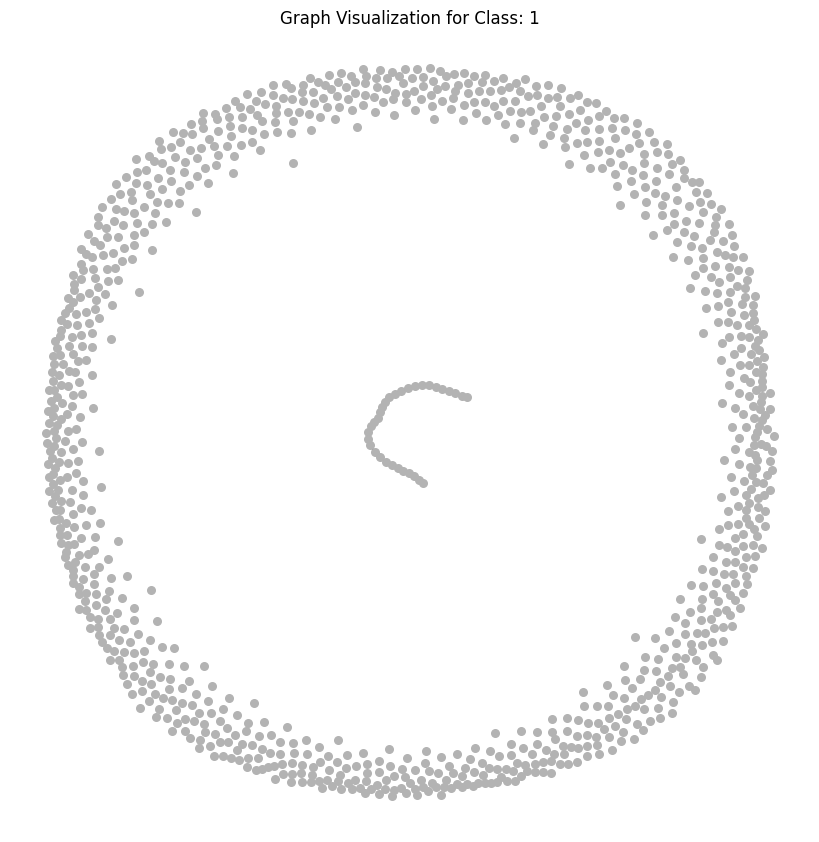

Visualizing Graph for Class: 2


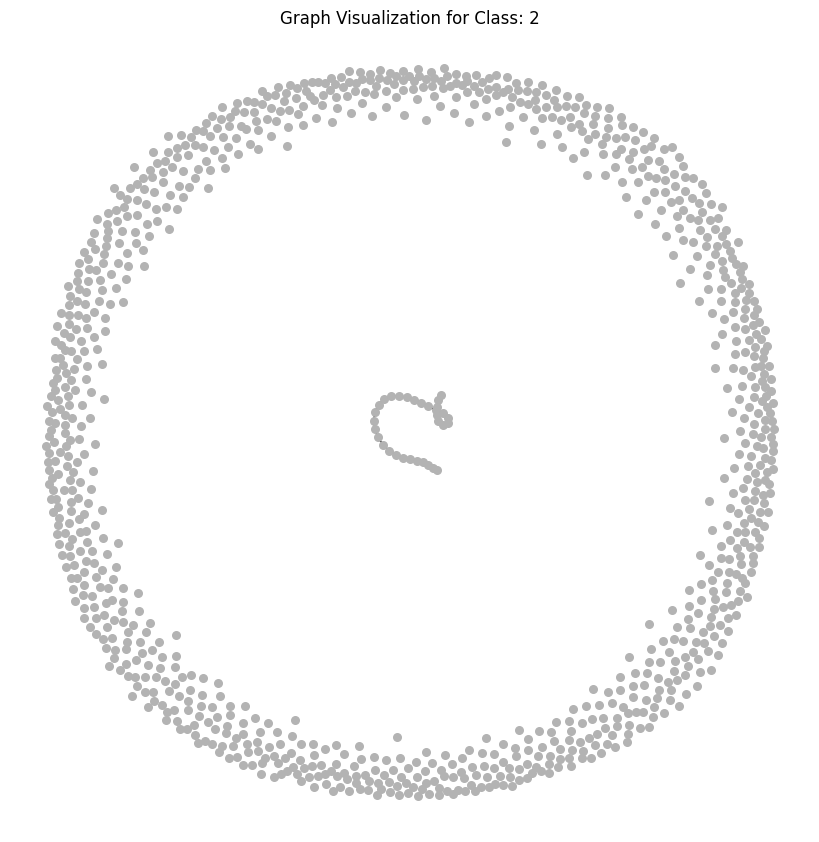

Visualizing Graph for Class: 3


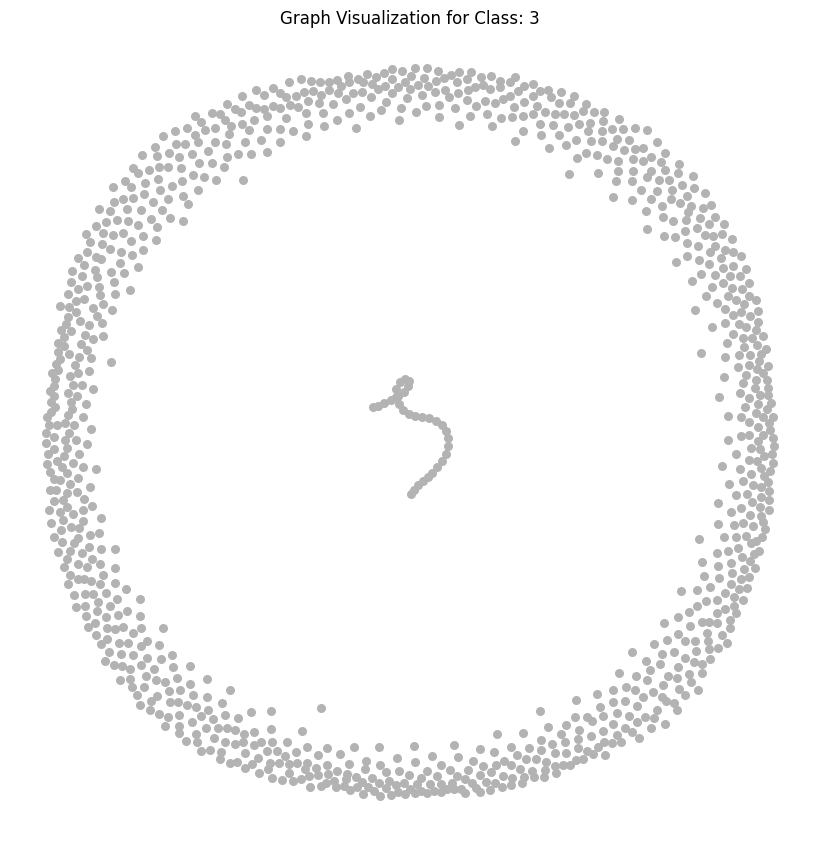

Visualizing Graph for Class: 4


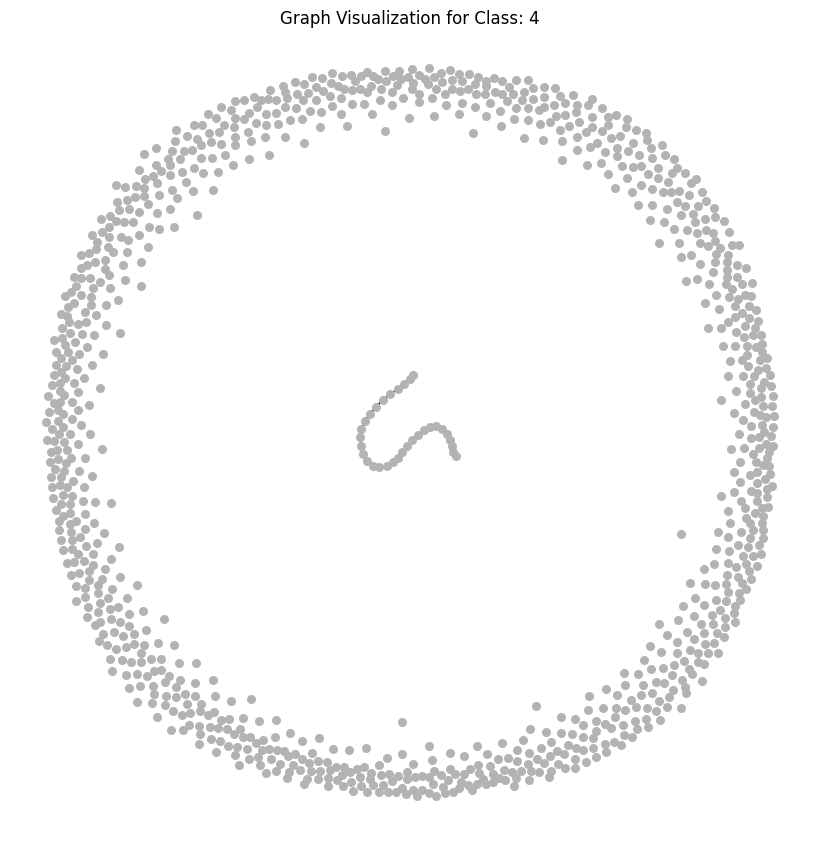

Visualizing Graph for Class: 5


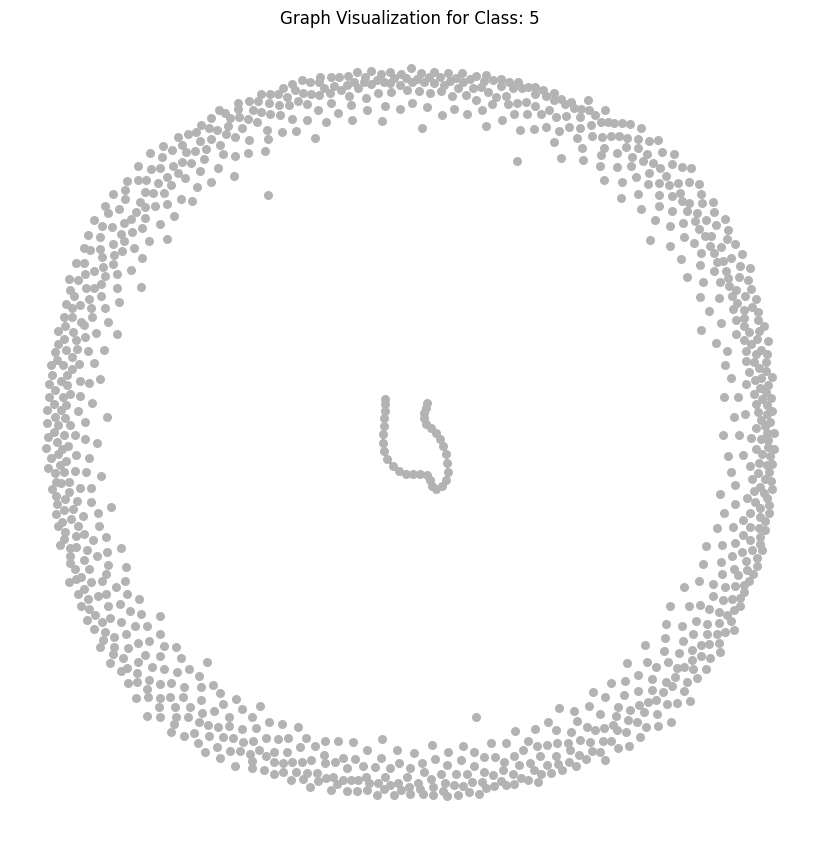

Visualizing Graph for Class: 6


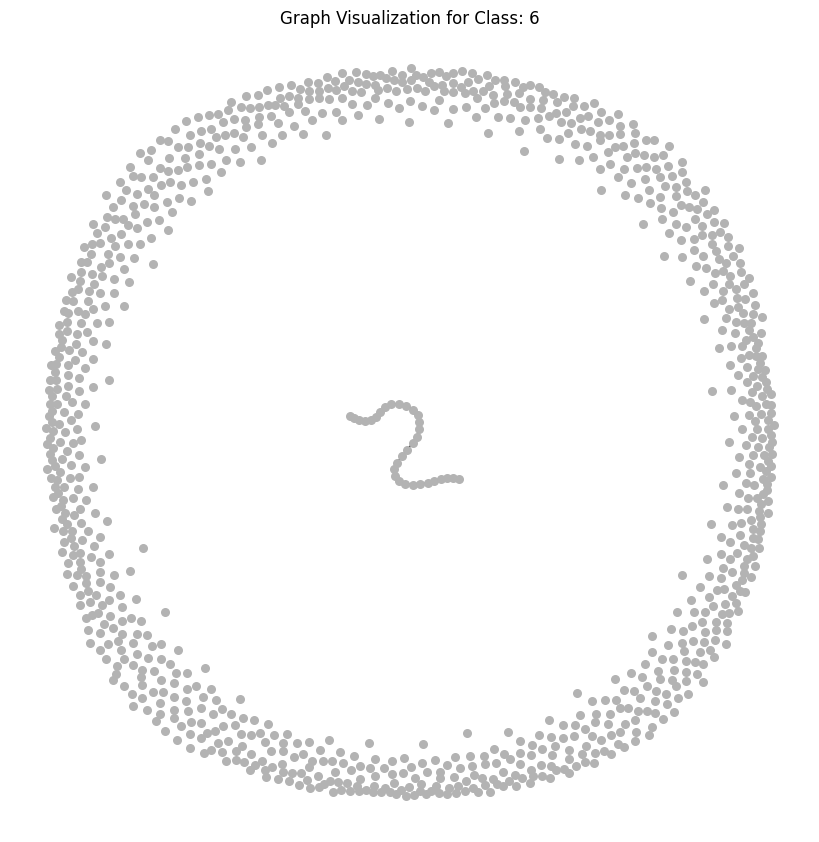

Visualizing Graph for Class: 7


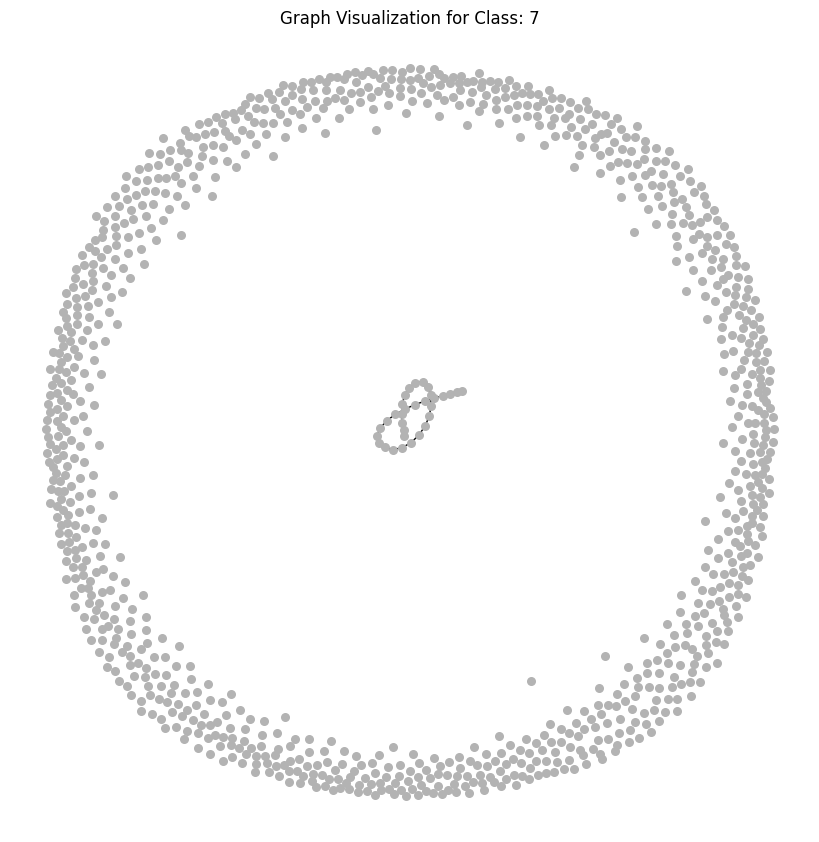

Visualizing Graph for Class: 8


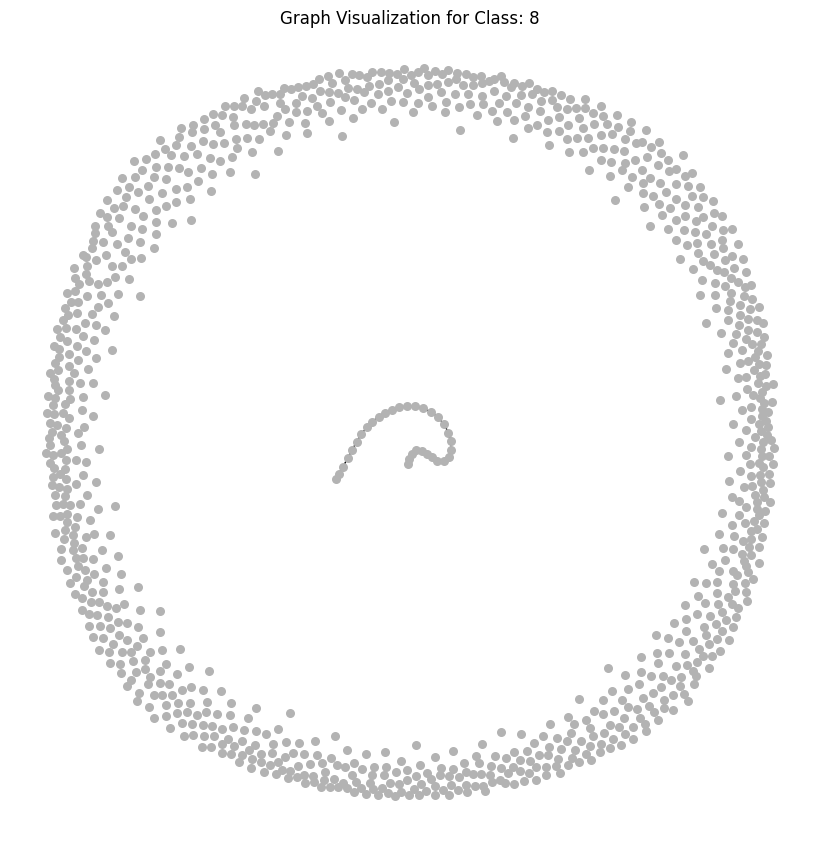

Visualizing Graph for Class: 9


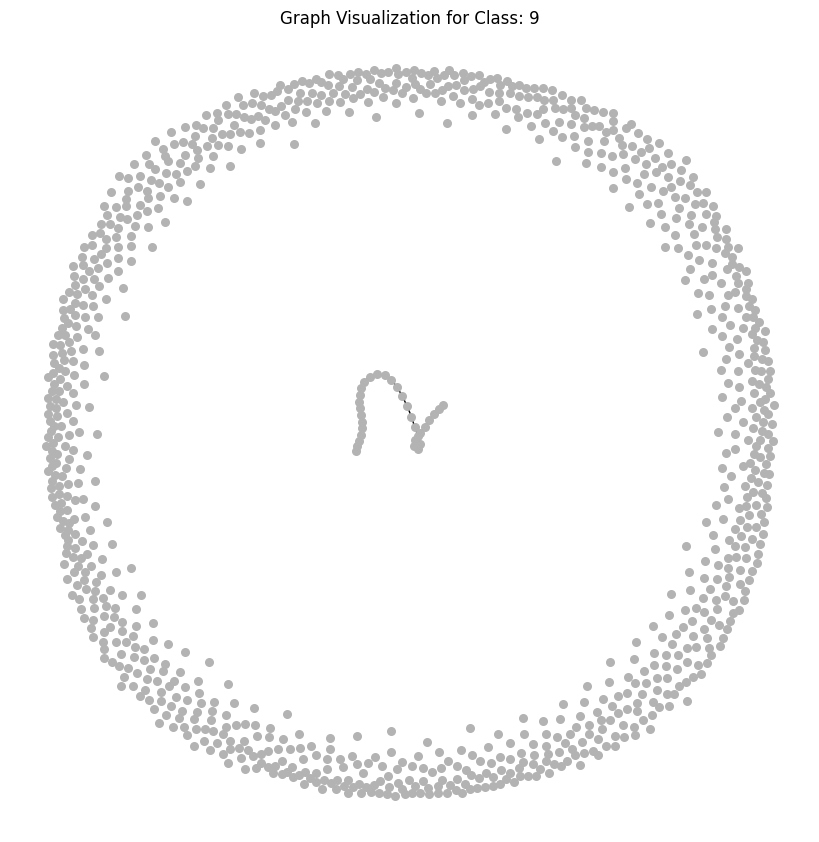

Visualizing Graph for Class: A


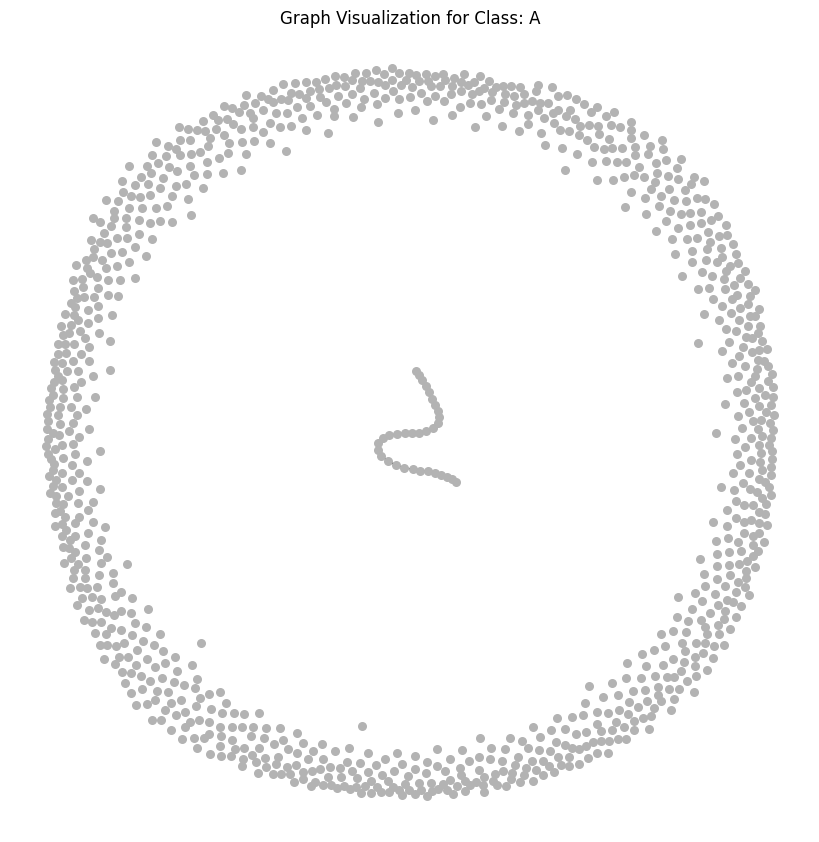

Visualizing Graph for Class: B


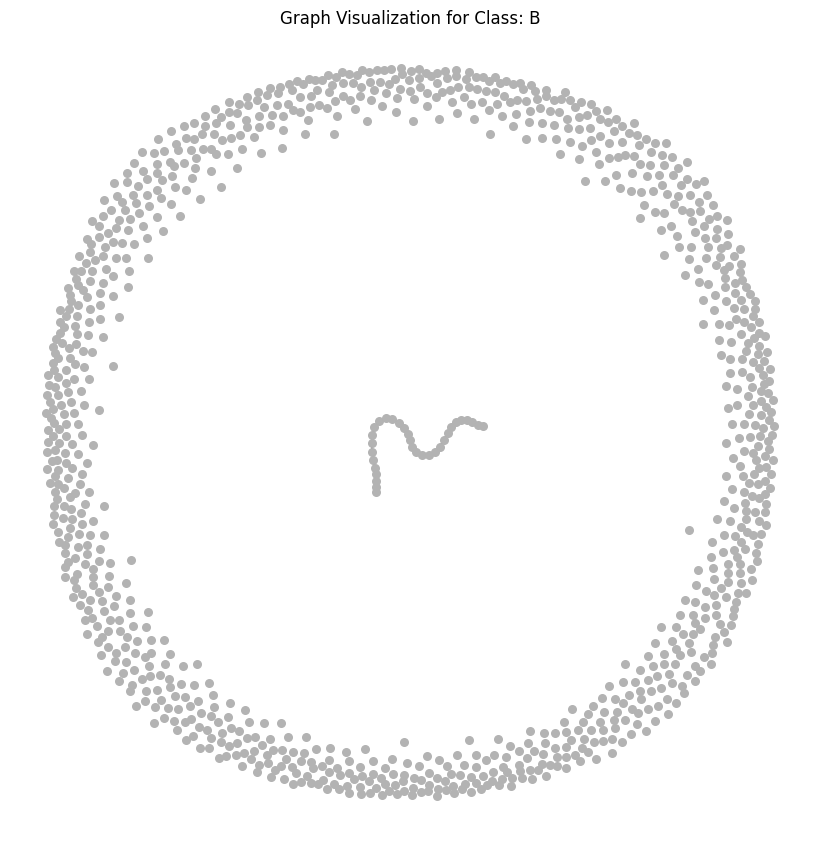

Visualizing Graph for Class: C


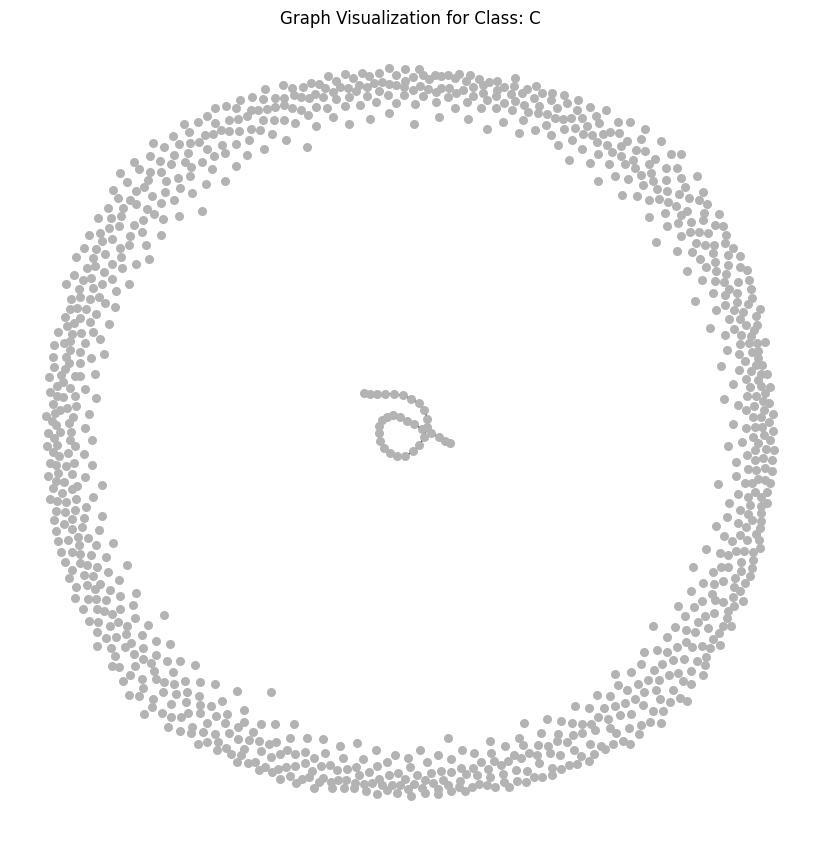

Visualizing Graph for Class: D


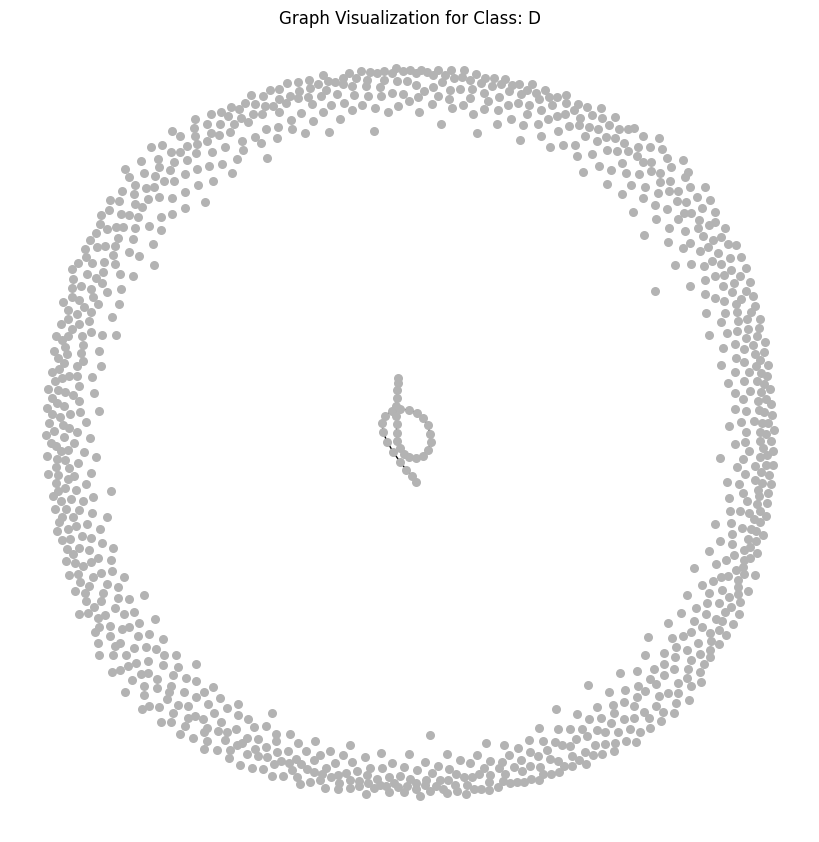

Visualizing Graph for Class: E


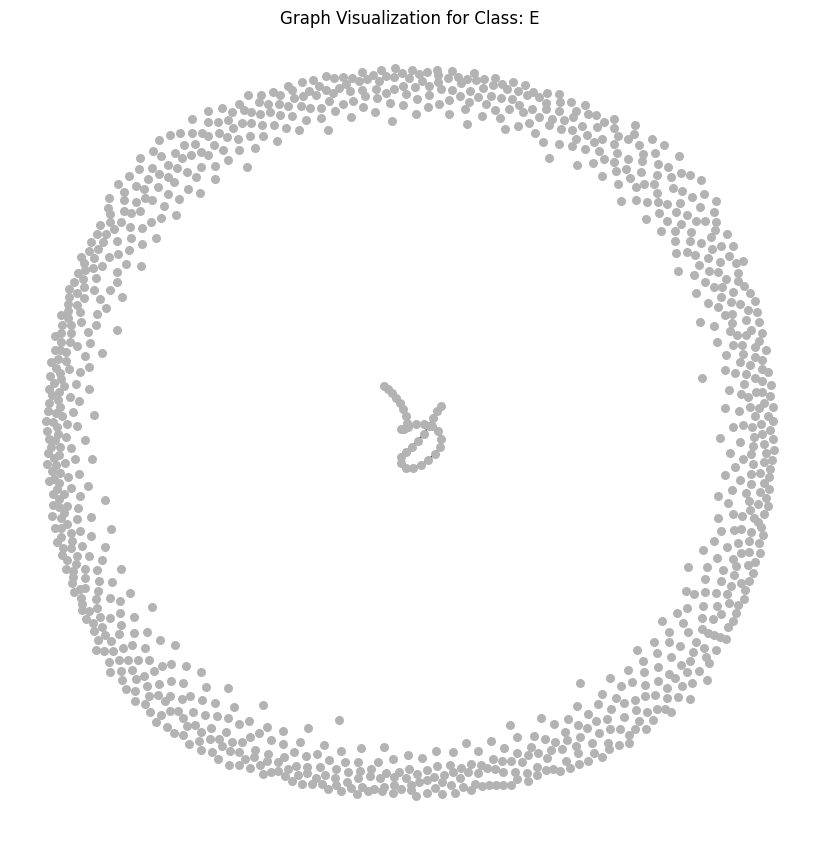

Visualizing Graph for Class: F


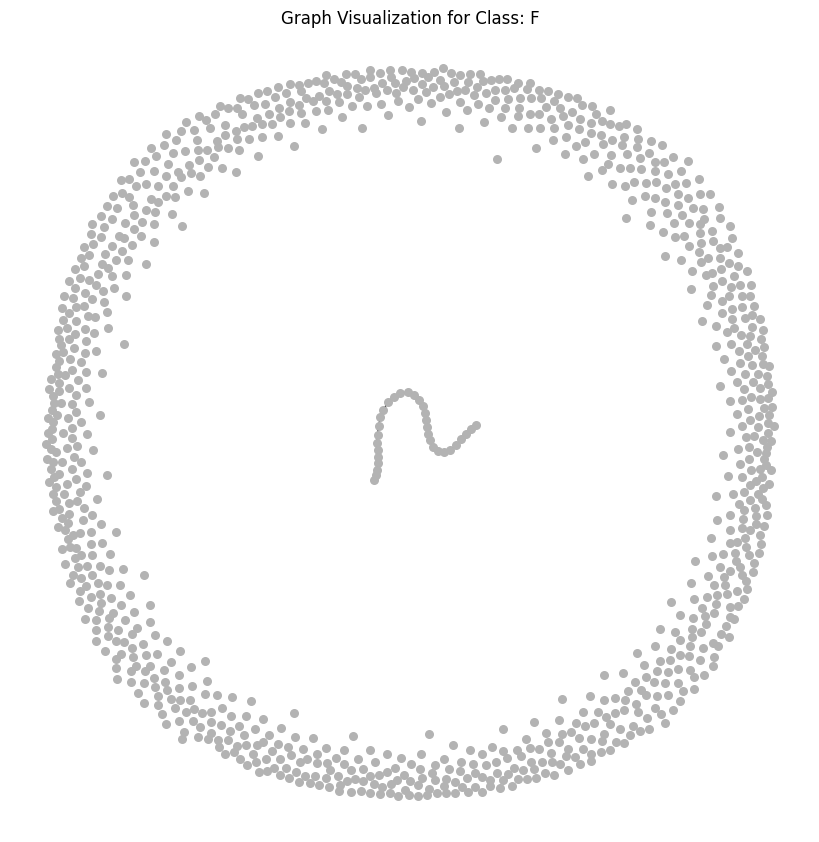

Visualizing Graph for Class: G


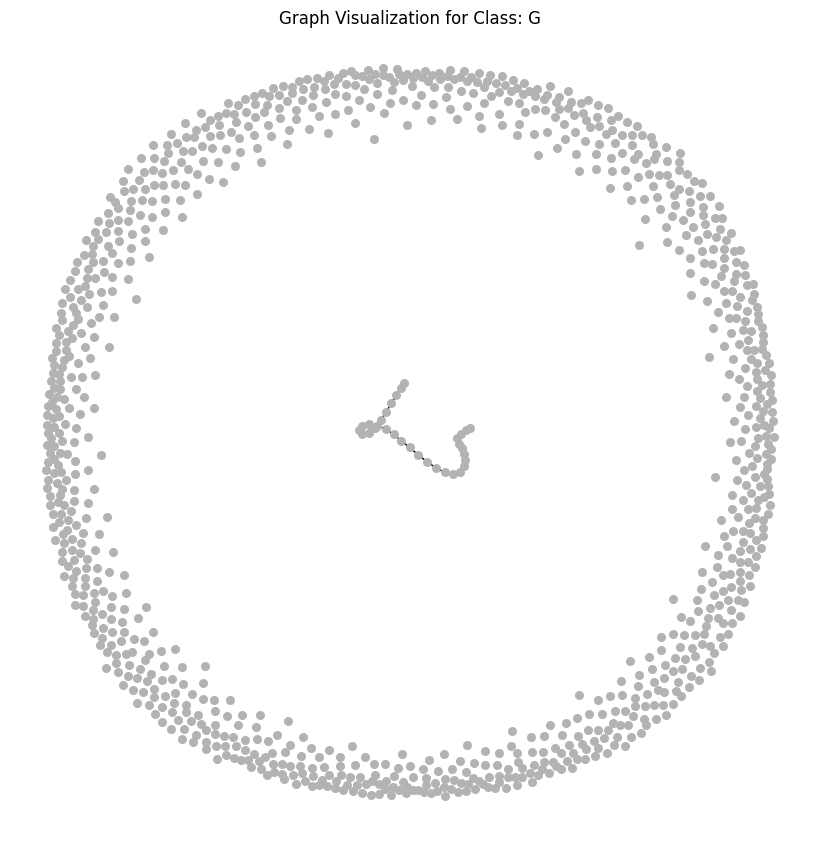

Visualizing Graph for Class: H


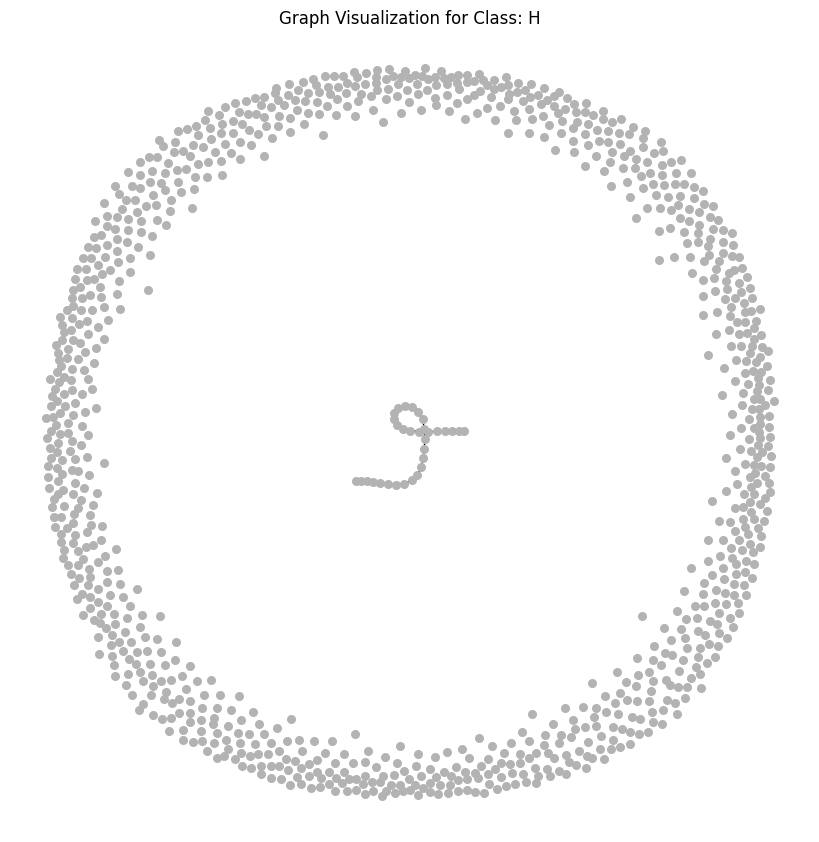

Visualizing Graph for Class: I


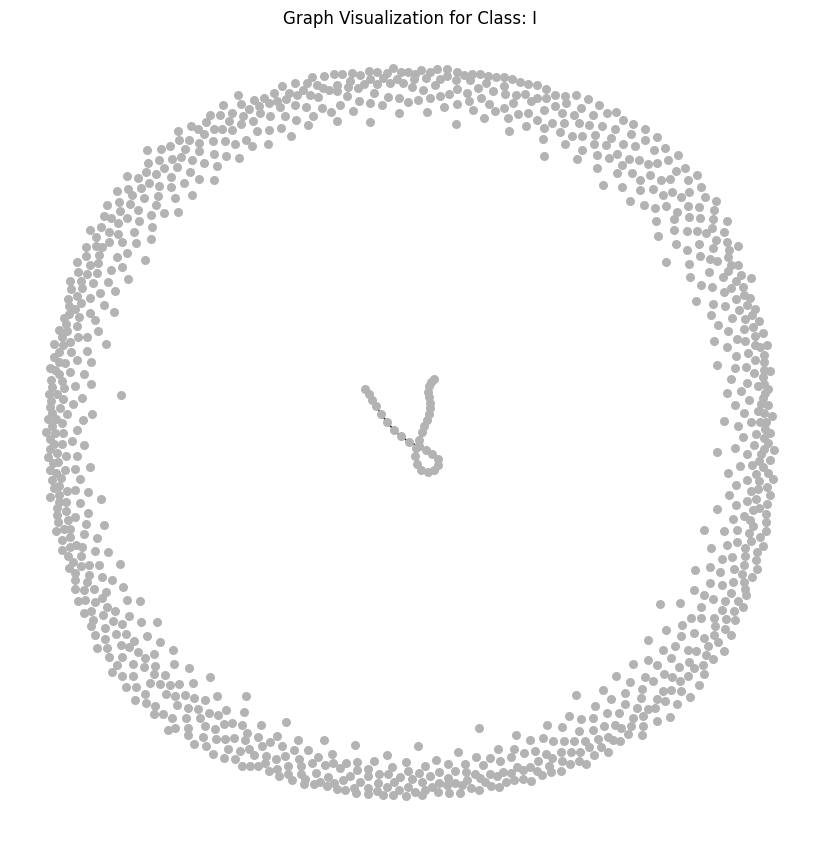

Visualizing Graph for Class: J


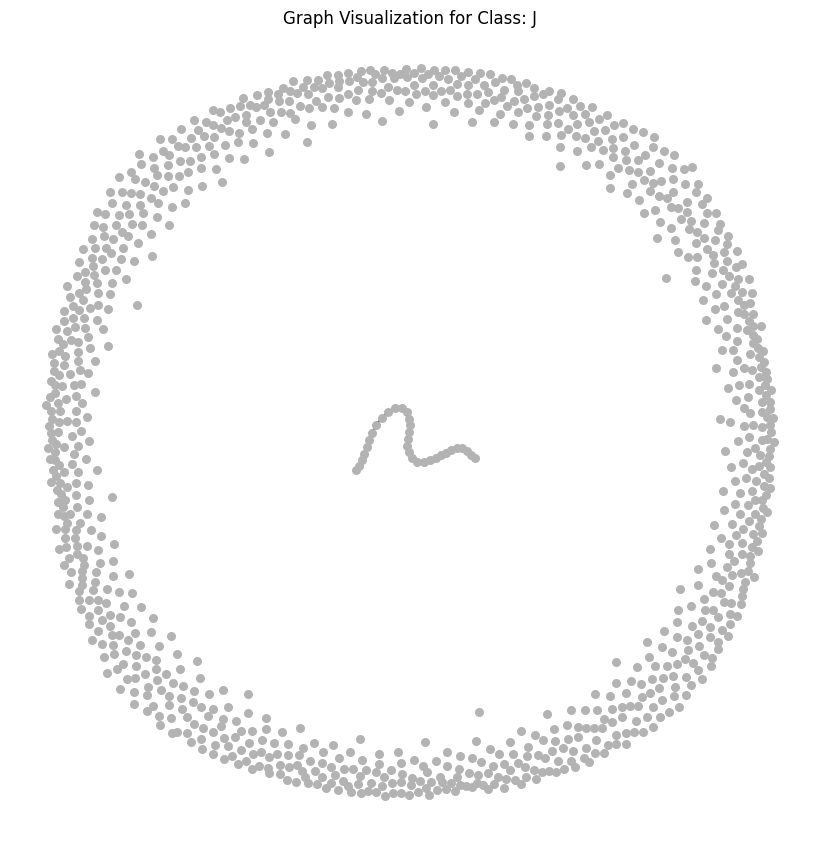

Visualizing Graph for Class: K


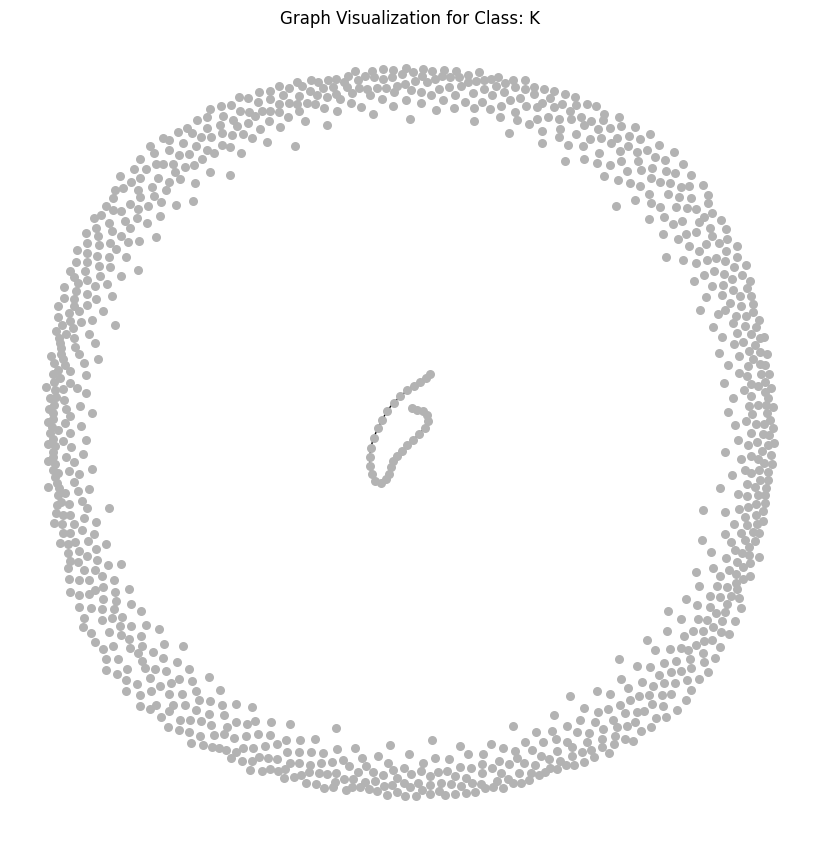

Visualizing Graph for Class: L


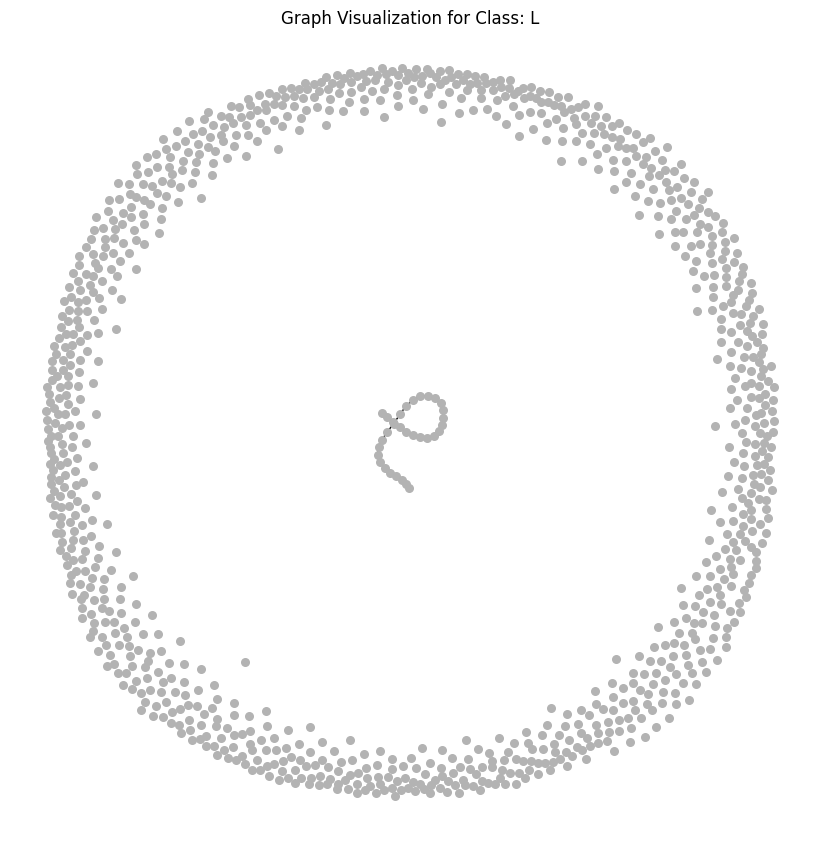

Visualizing Graph for Class: M


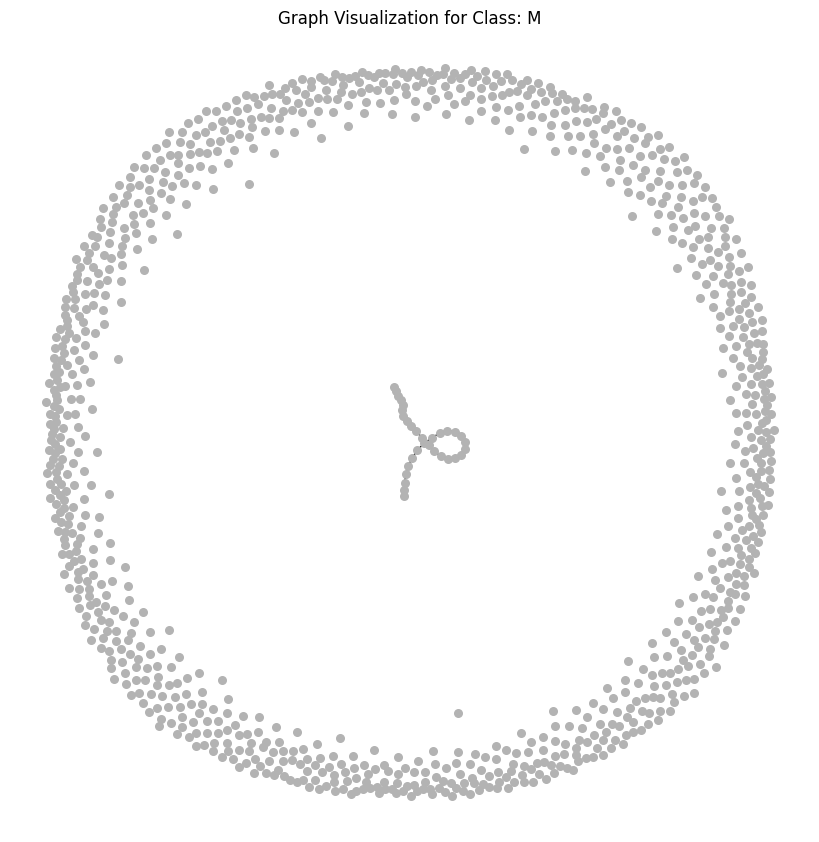

Visualizing Graph for Class: N


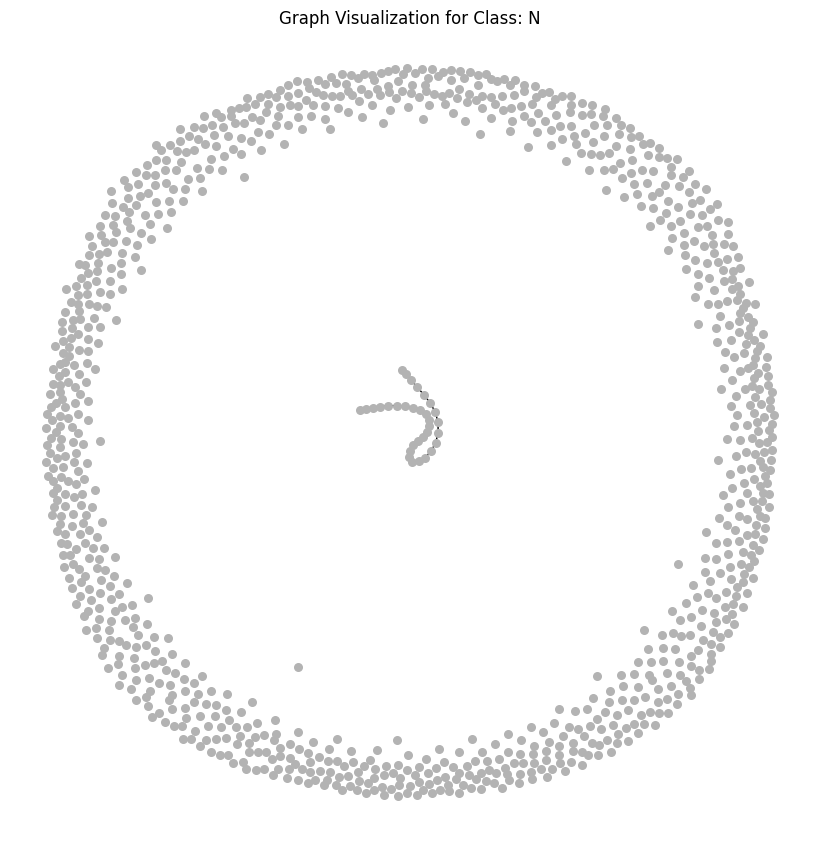

Visualizing Graph for Class: O


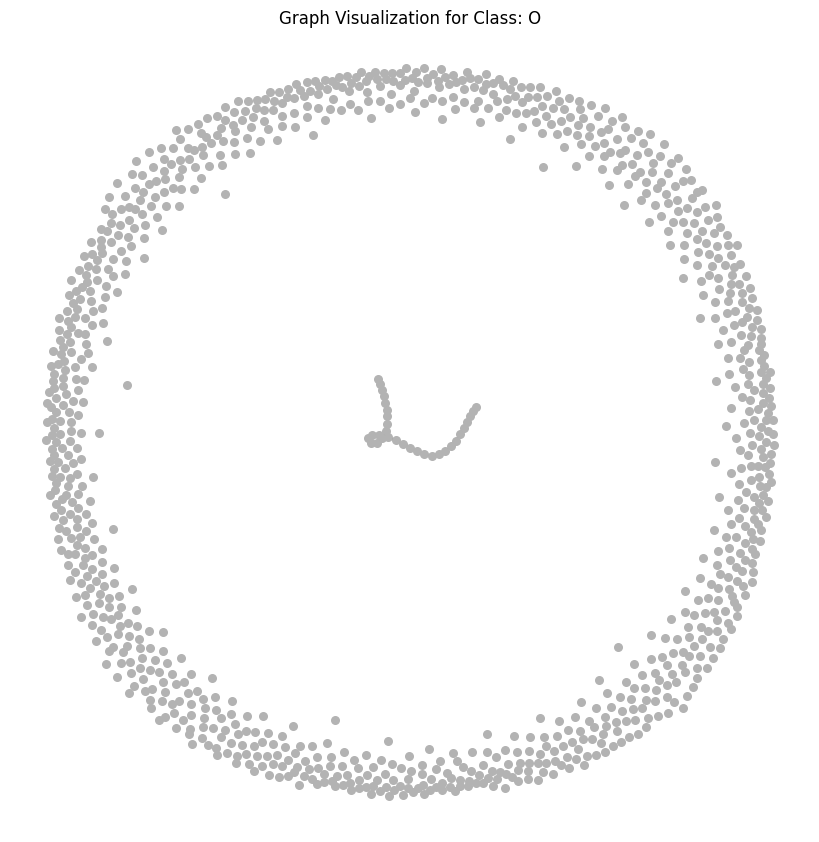

Visualizing Graph for Class: P


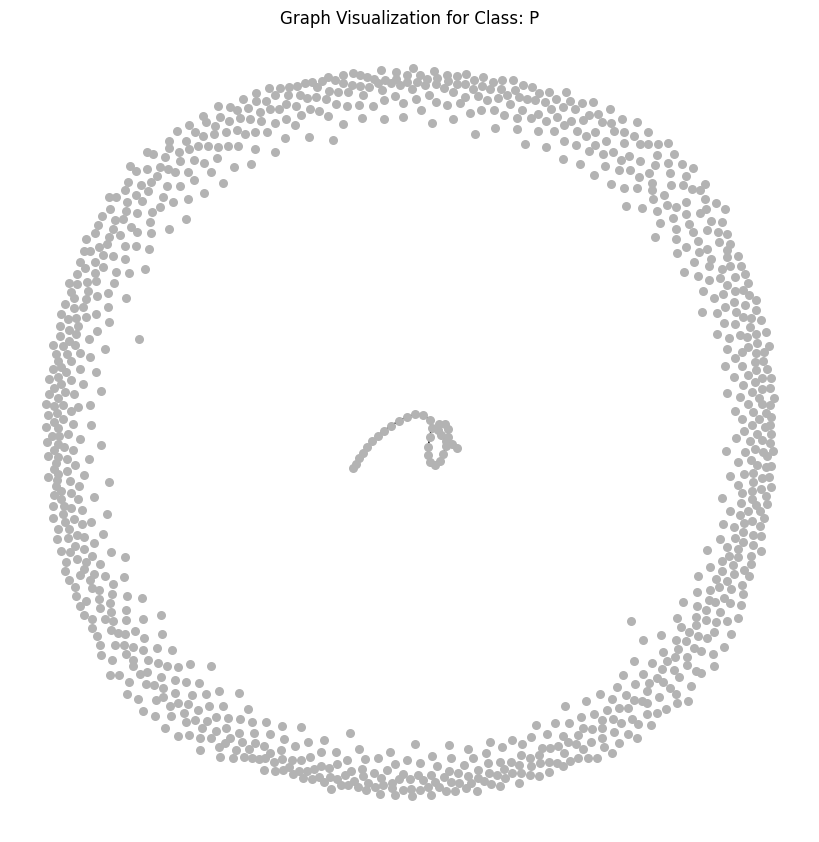

Visualizing Graph for Class: Q


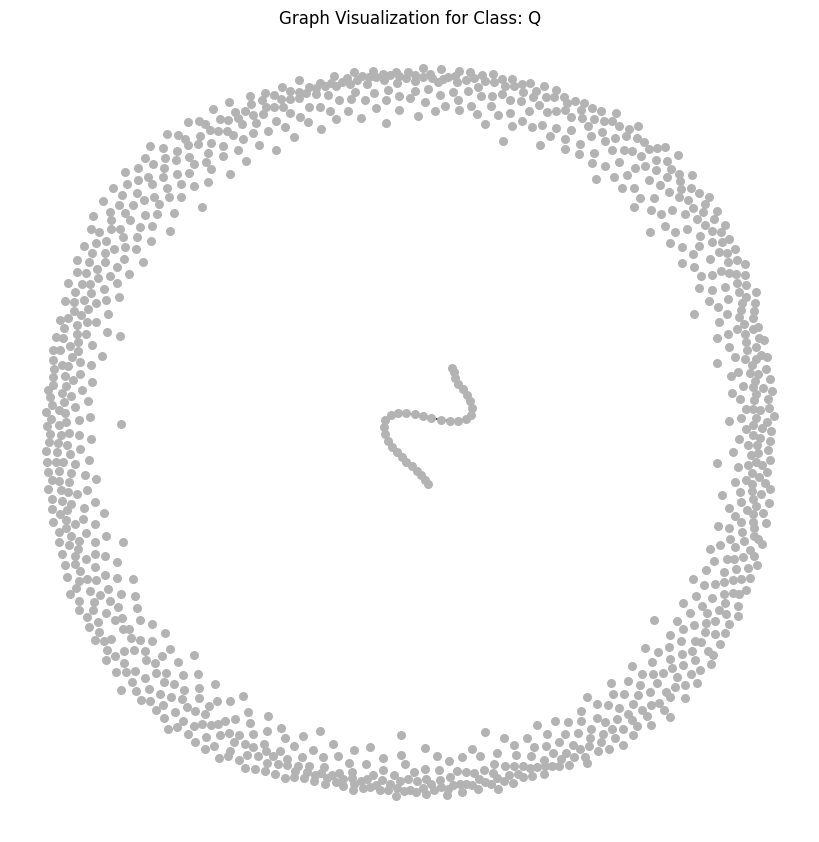

Visualizing Graph for Class: R


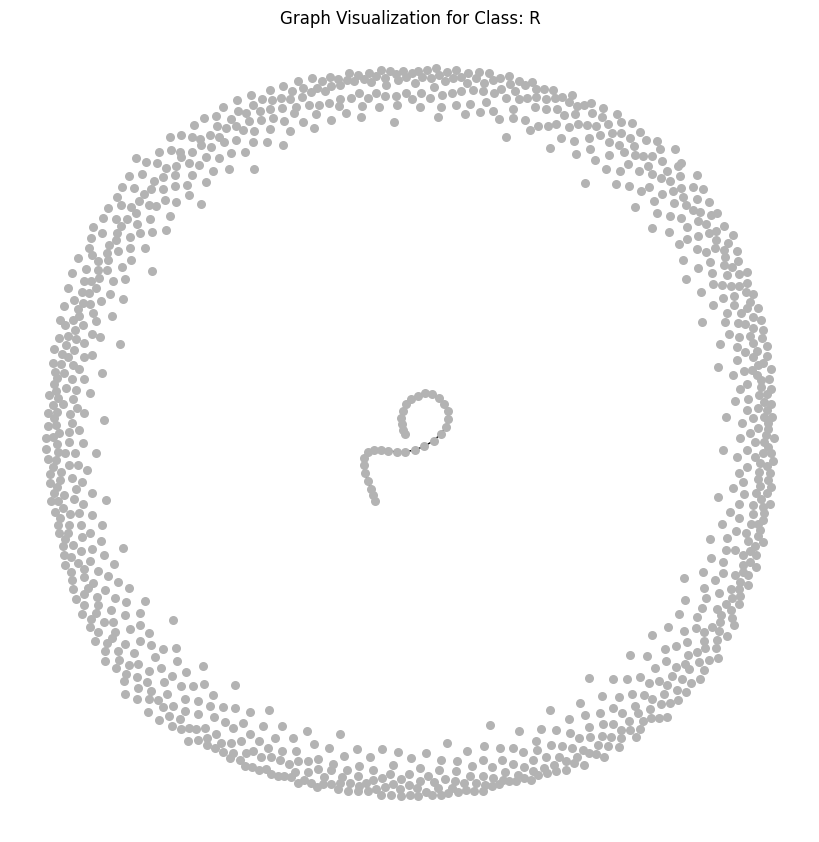

Visualizing Graph for Class: S


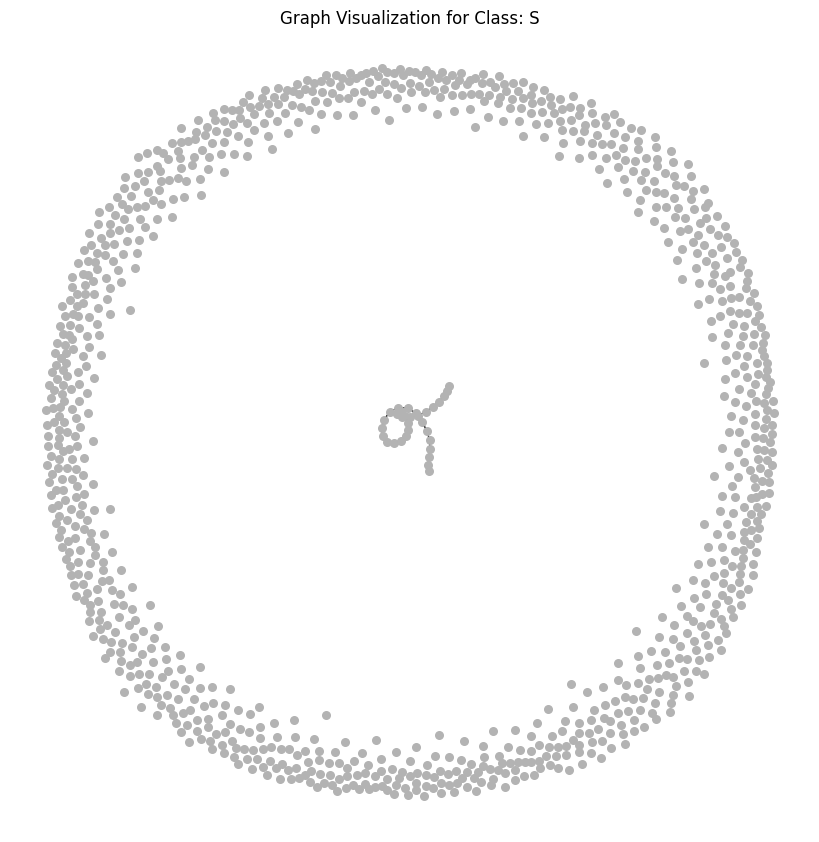

Visualizing Graph for Class: T


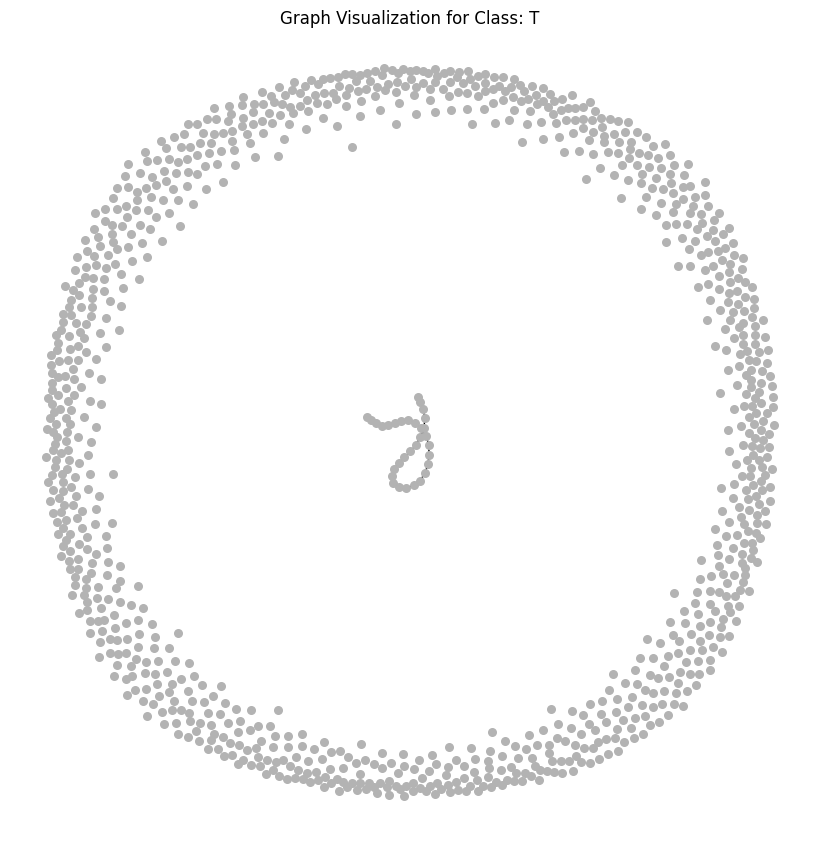

Visualizing Graph for Class: U


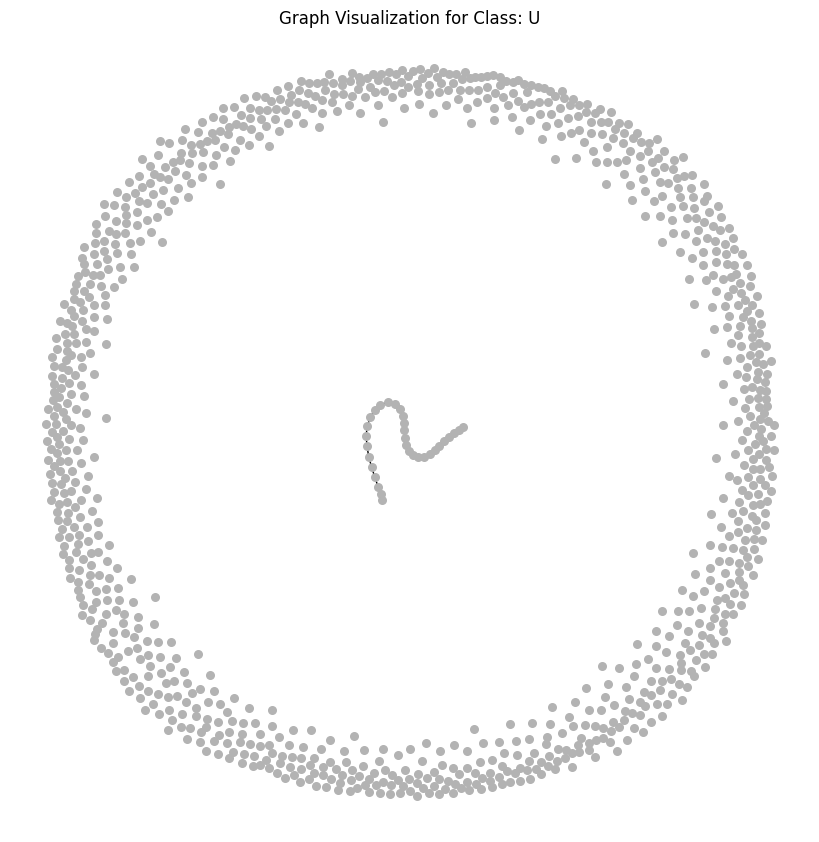

Visualizing Graph for Class: V


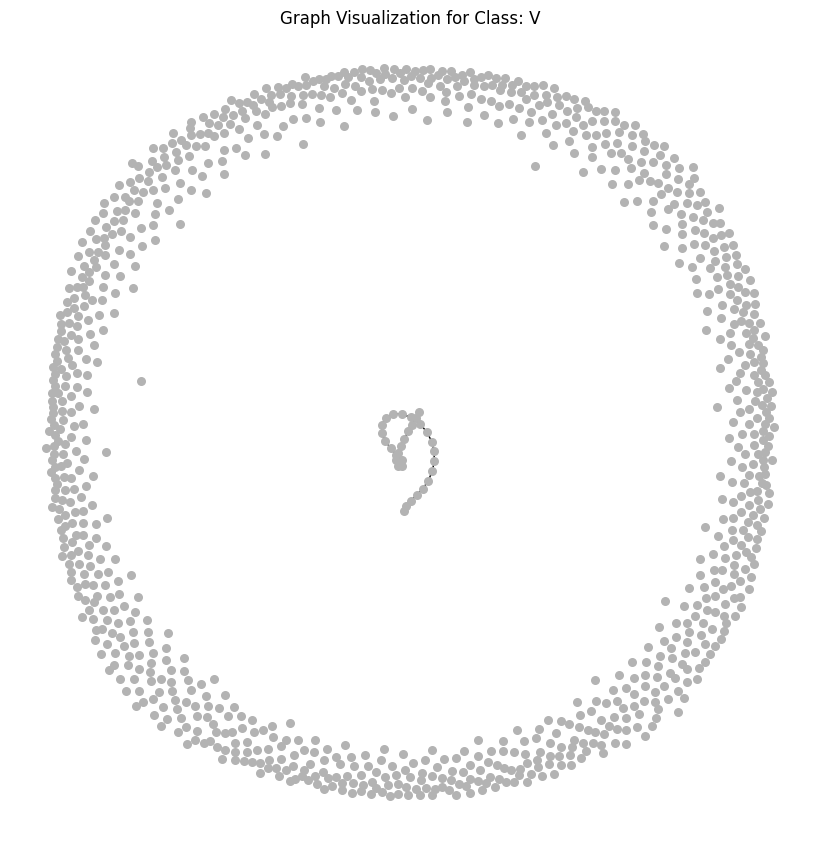

Visualizing Graph for Class: W


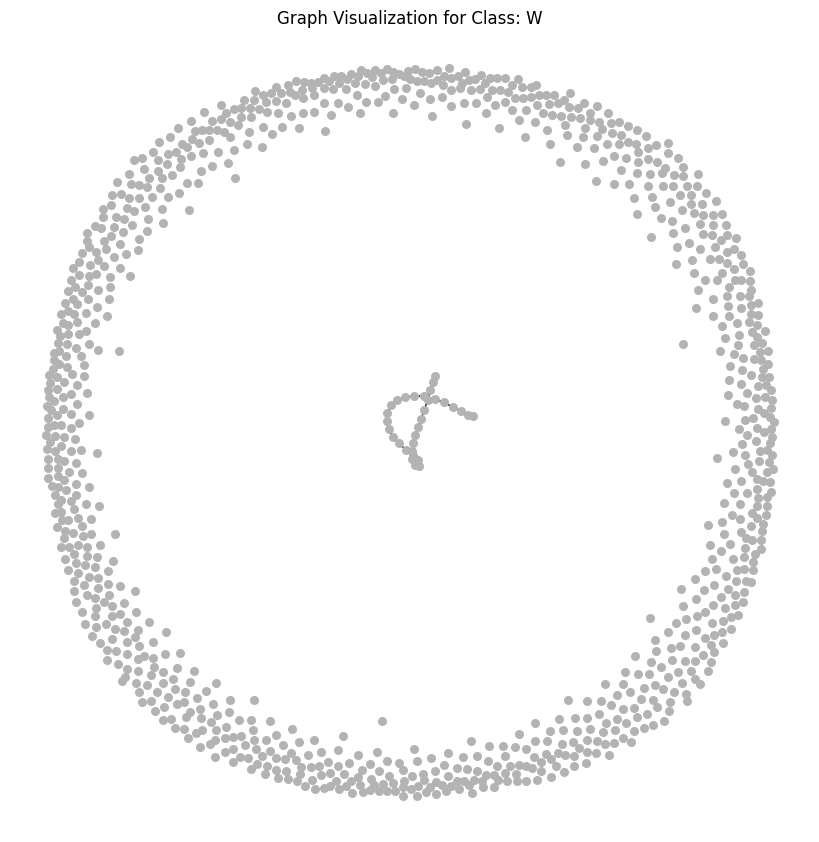

Visualizing Graph for Class: X


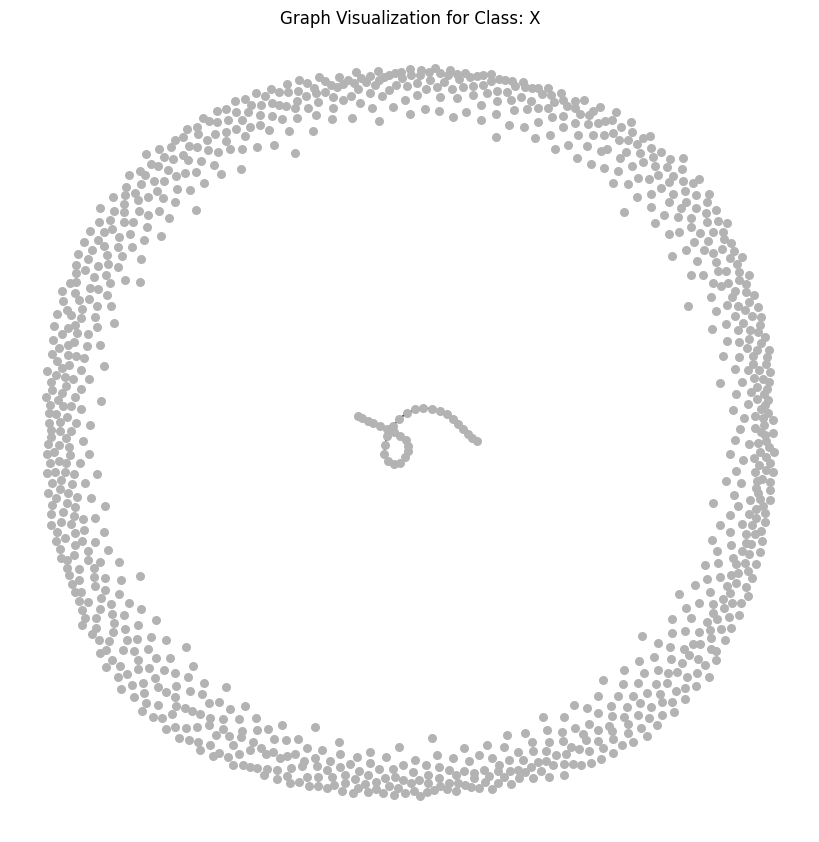

Visualizing Graph for Class: Y


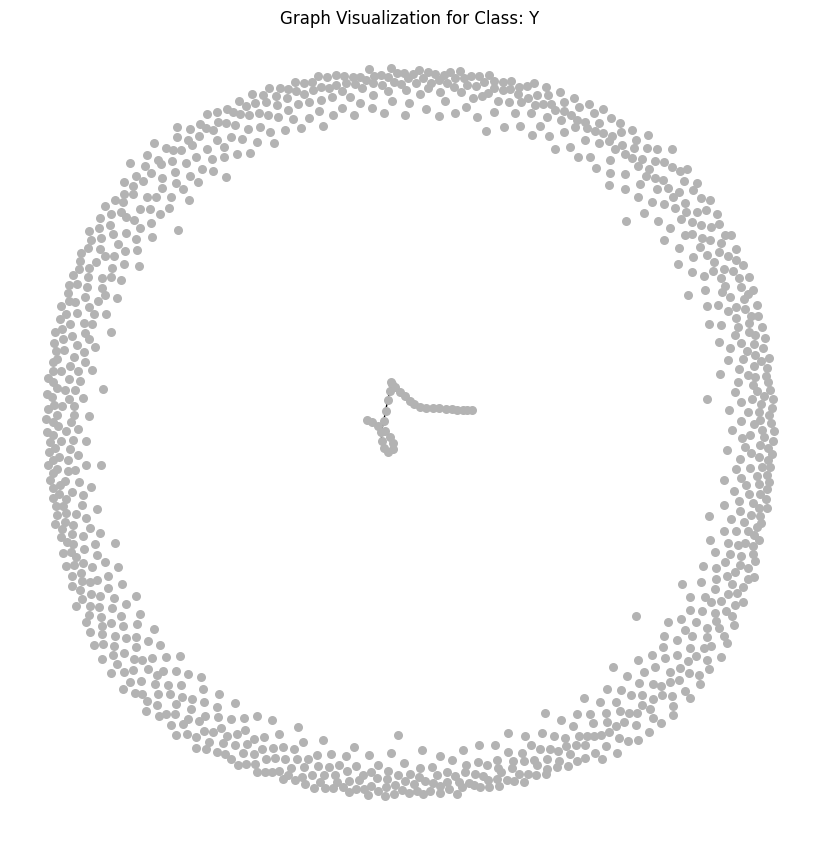

Visualizing Graph for Class: Z


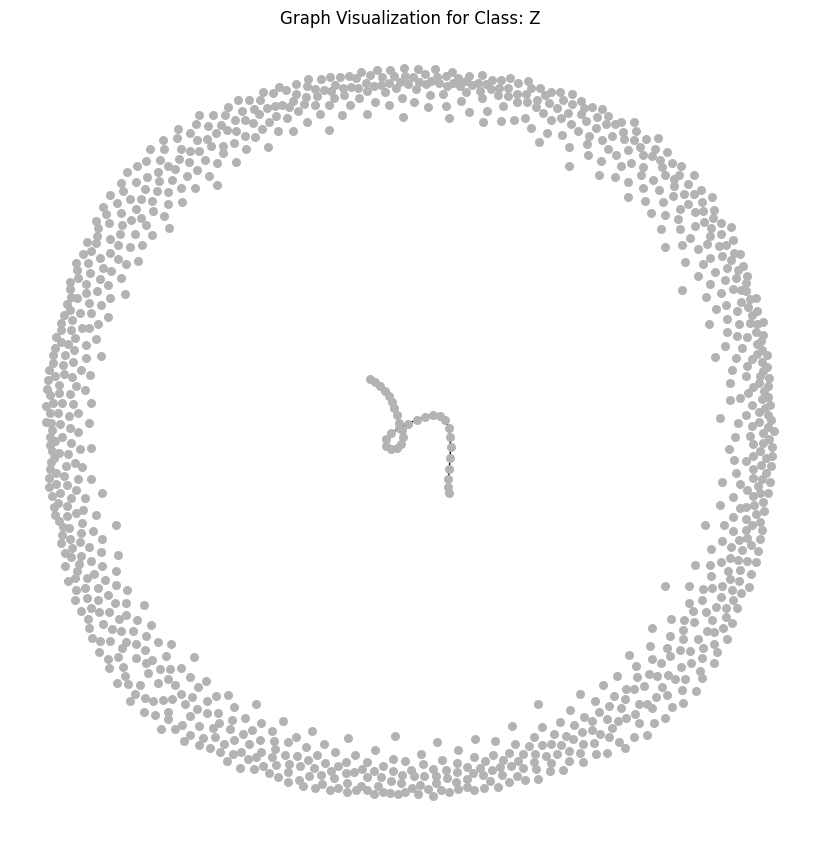

In [21]:
#To view the saved graphs
import os
import pickle
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def view_graph_from_each_class(base_dir="content/savegraphs"):
    # Iterate over classes
    for class_name in sorted(os.listdir(base_dir)):
        class_dir = os.path.join(base_dir, class_name)

        # Output class name at the 'top' of each visualization in this execution cycle
        print(f"Visualizing Graph for Class: {class_name}\n{'=' * 50}")  # This acts as a dynamic 'comment'

        # Pick one graph file per class
        graph_files = os.listdir(class_dir)
        if not graph_files:
            print(f"No graphs found for class {class_name}.")
            continue
        graph_file_path = os.path.join(class_dir, graph_files[0])  # Just choosing the first graph for visualization

        # Load the graph
        with open(graph_file_path, 'rb') as file:
            graph = pickle.load(file)

        # Convert to NetworkX graph for visualization
        g = to_networkx(graph, to_undirected=True)

        # Visualization
        plt.figure(figsize=(8, 8))
        nx.draw(g, node_size=30, node_color=[[0.7, 0.7, 0.7]])
        plt.title(f"Graph Visualization for Class: {class_name}")
        plt.show()

# Call the function
view_graph_from_each_class()


###integrating both prediction and graph visualization

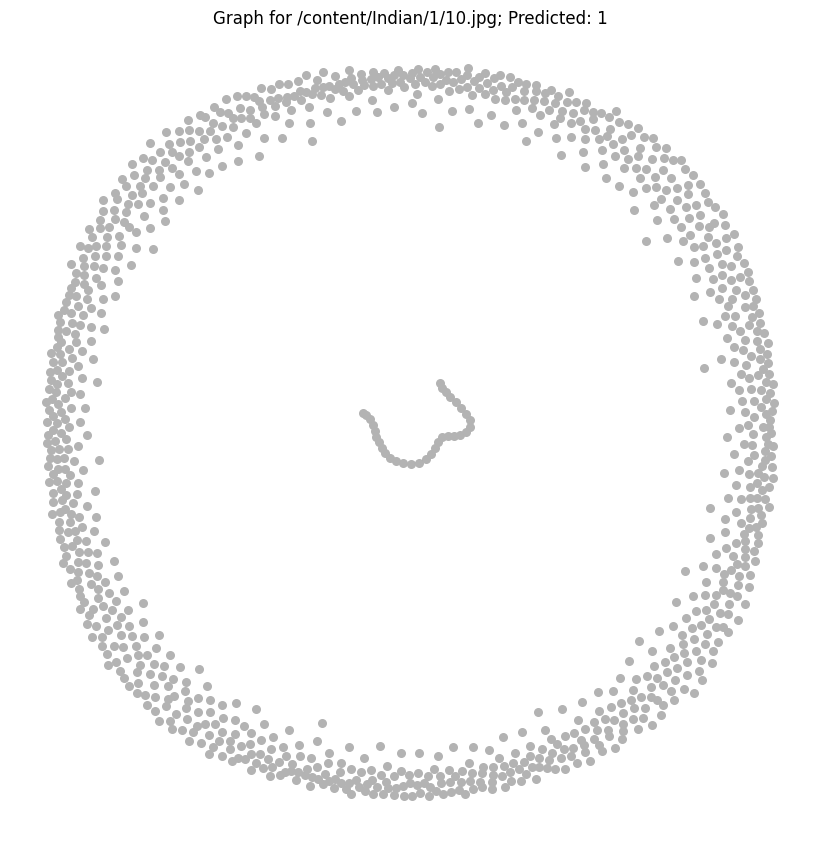

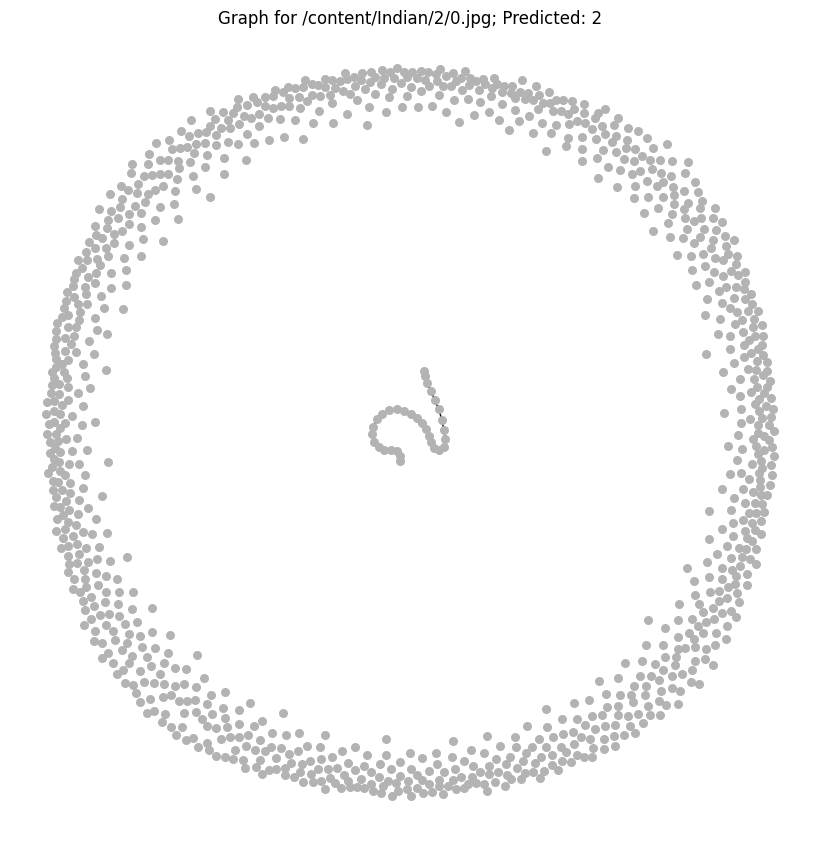

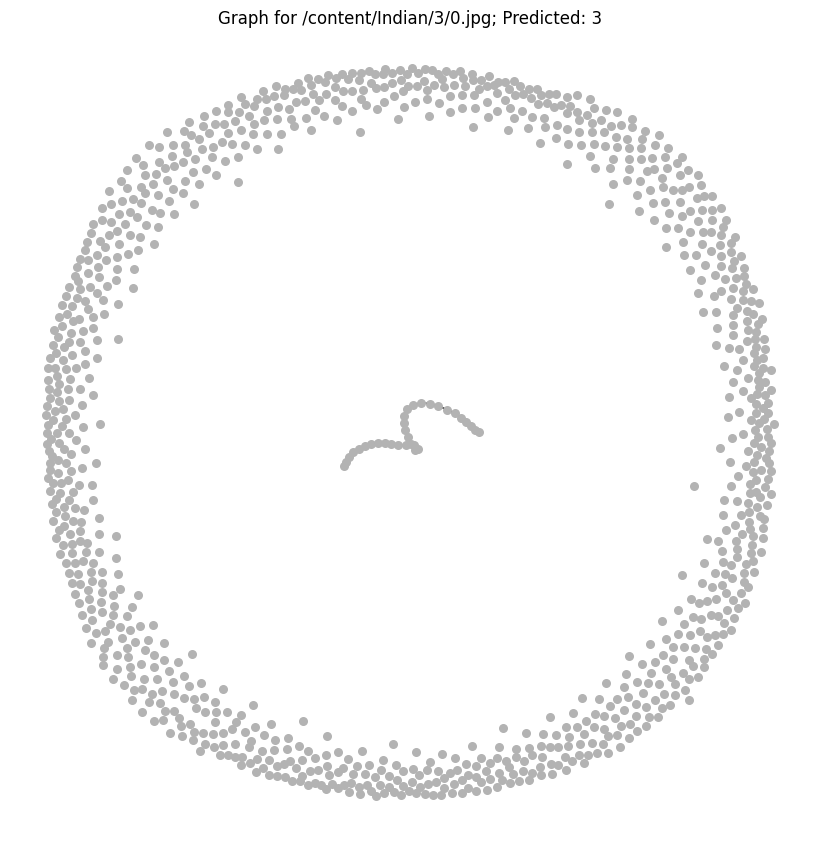

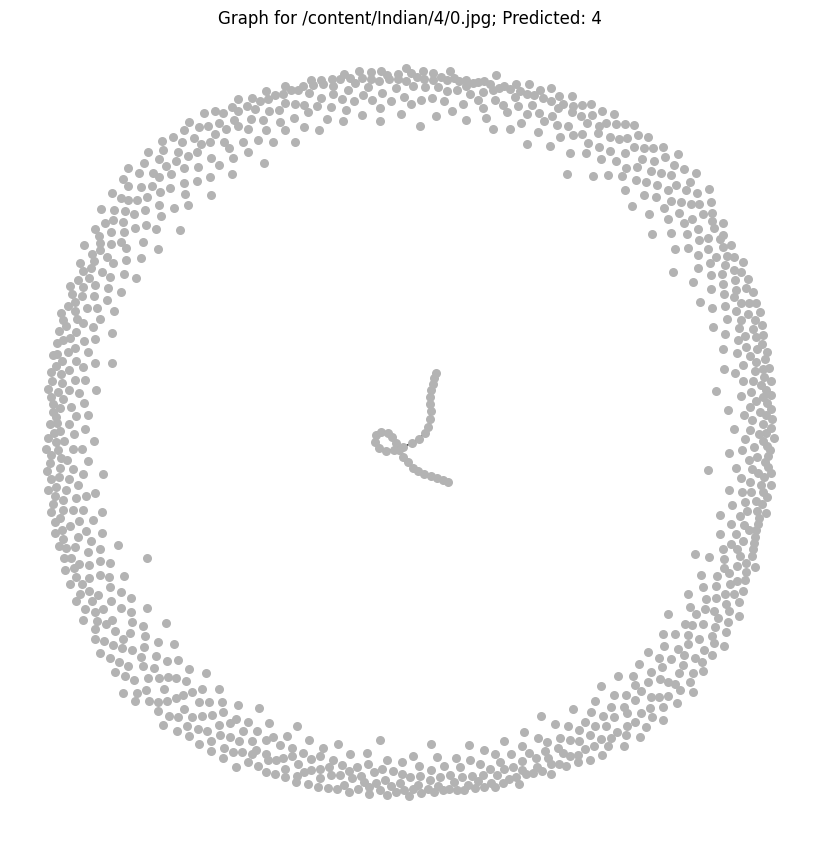

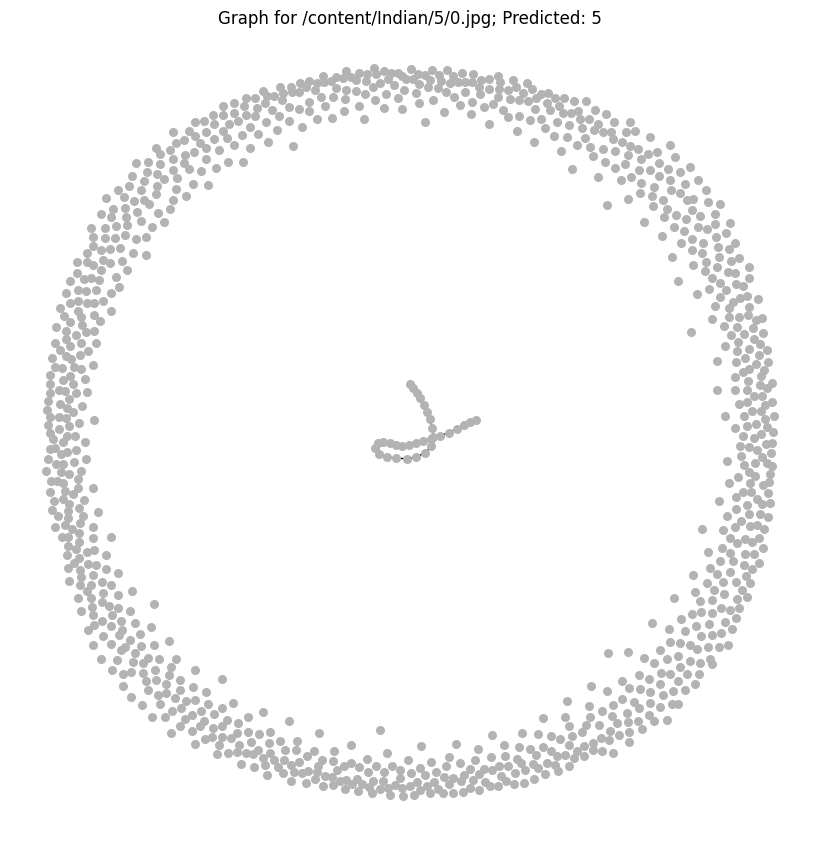

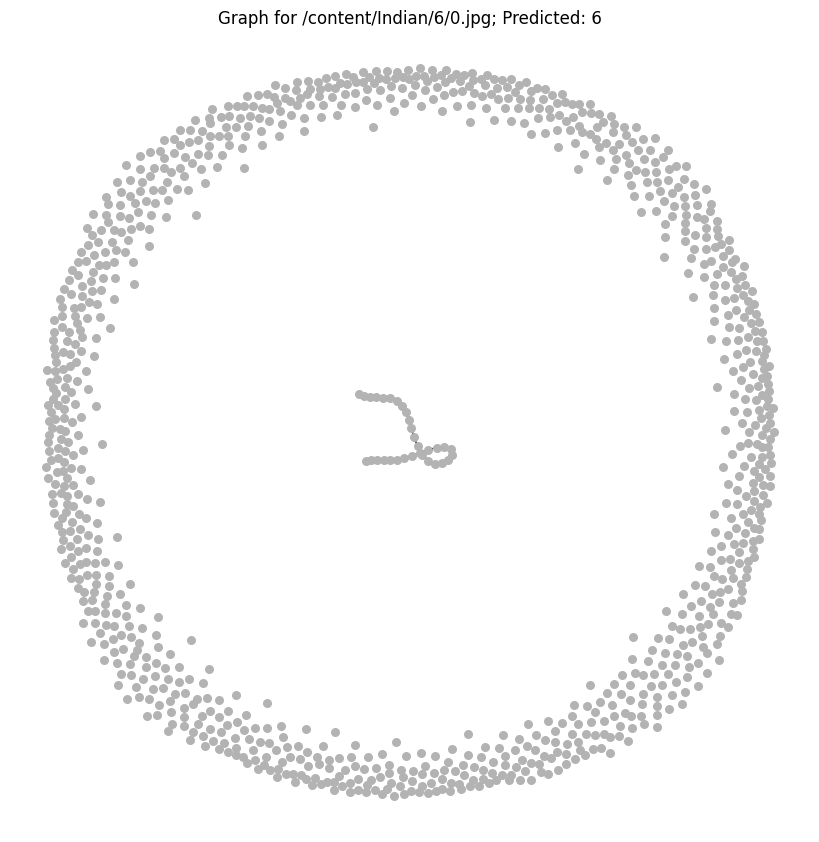

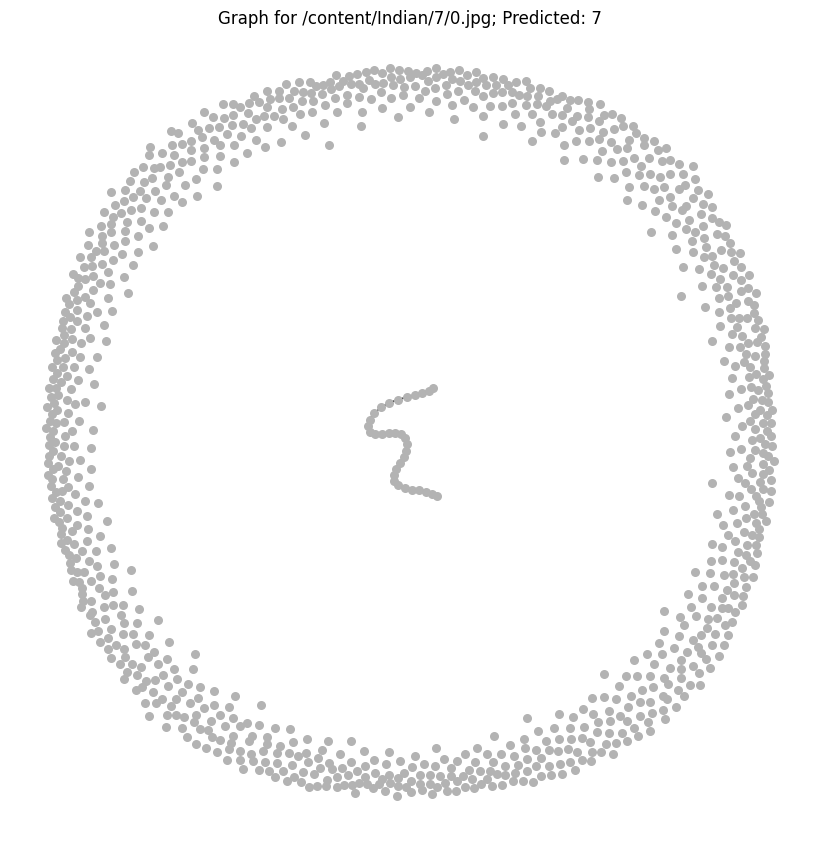

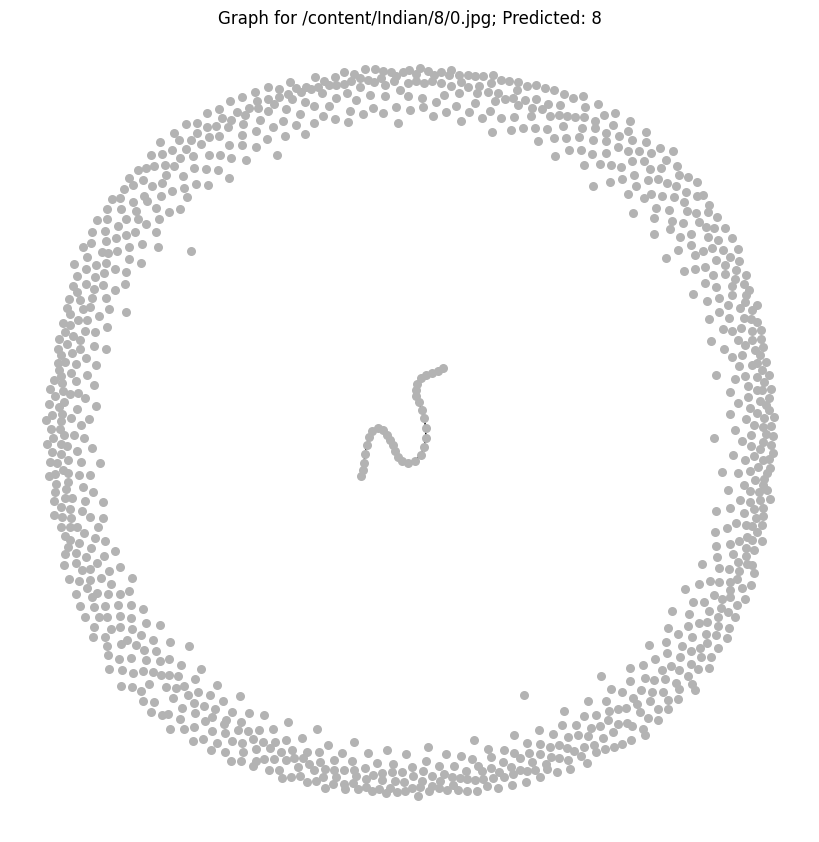

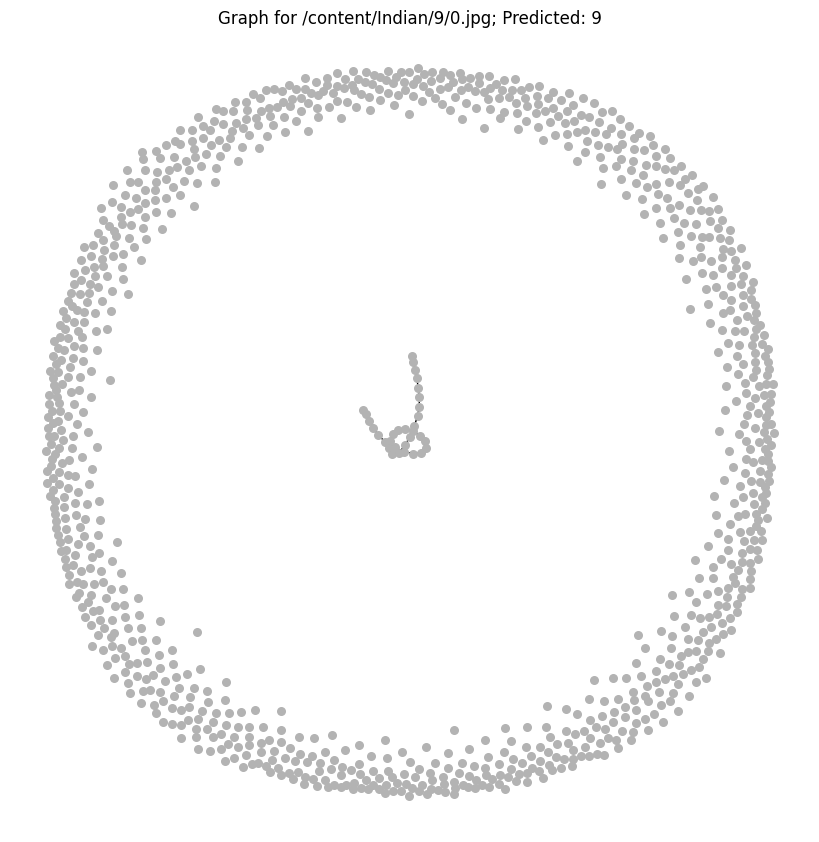

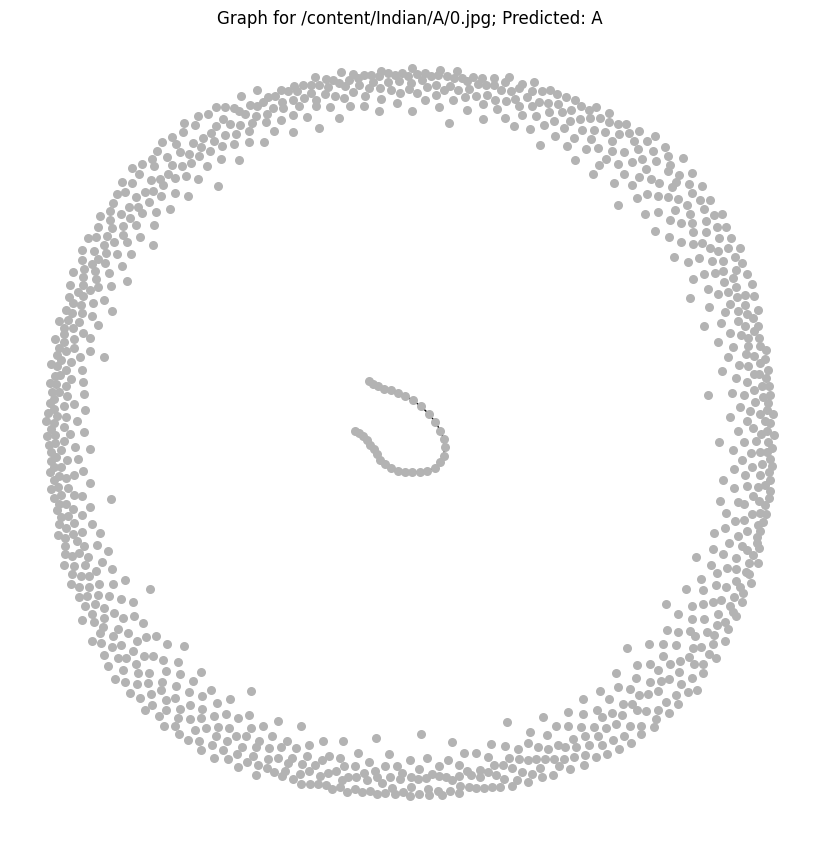

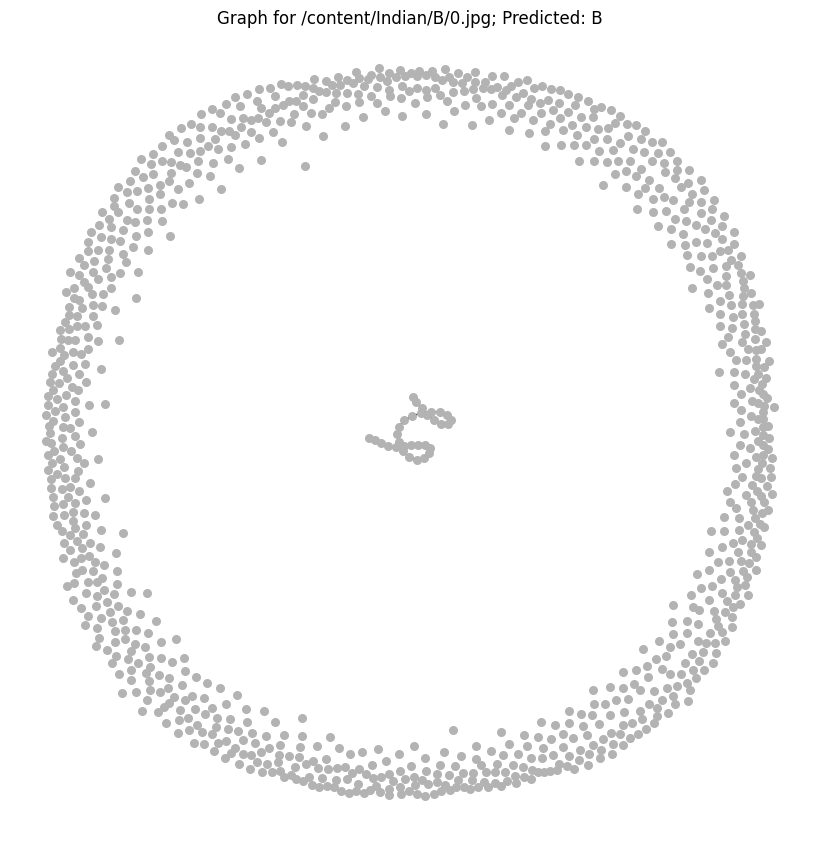

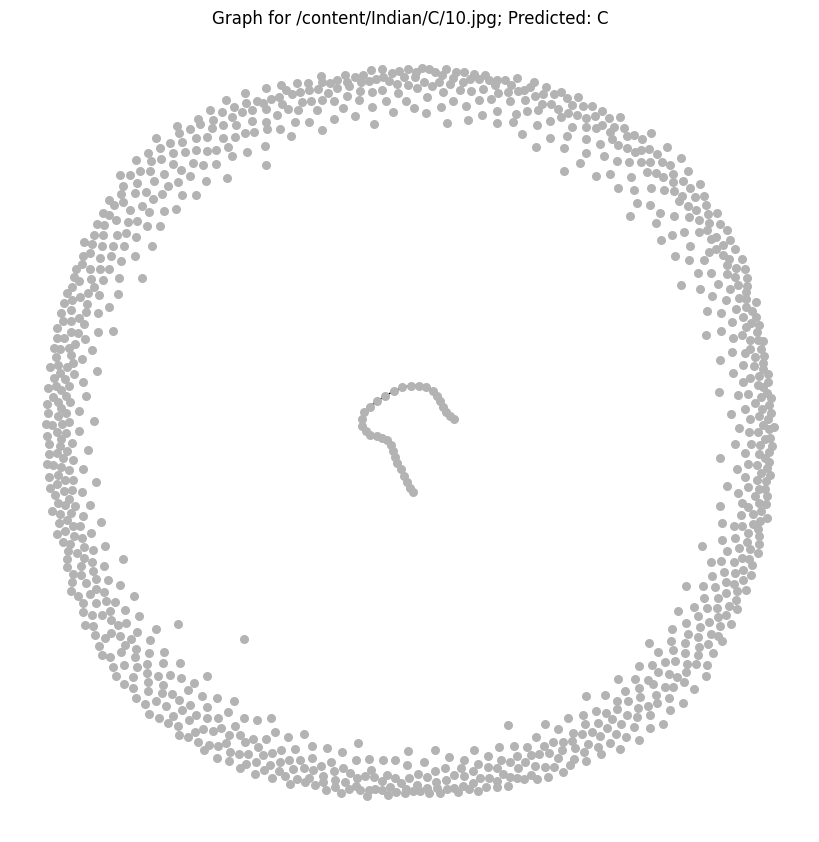

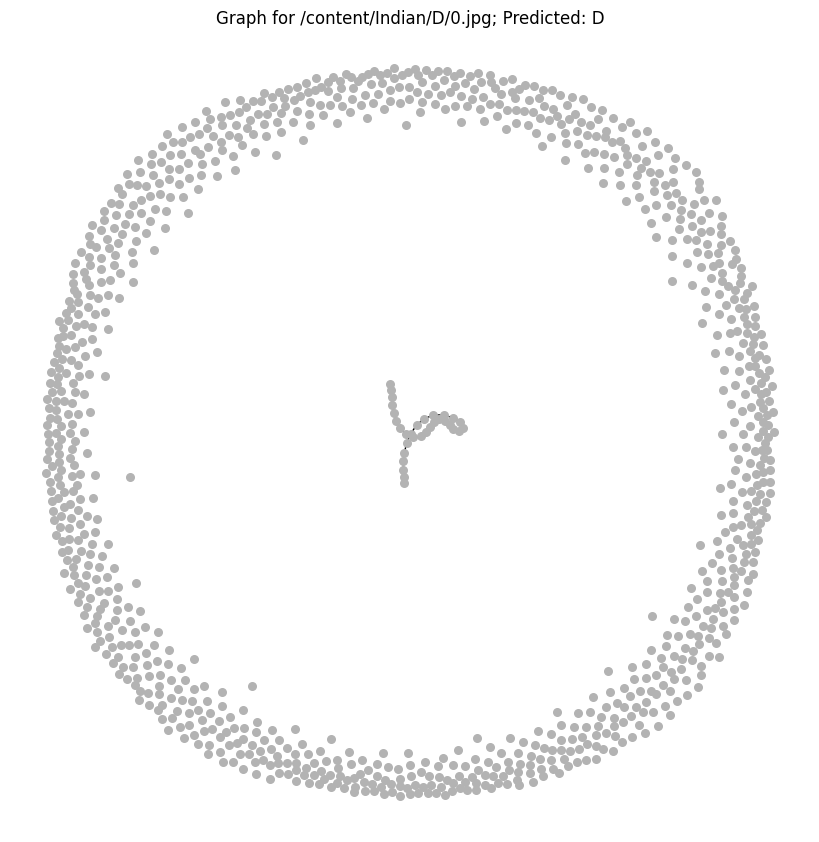

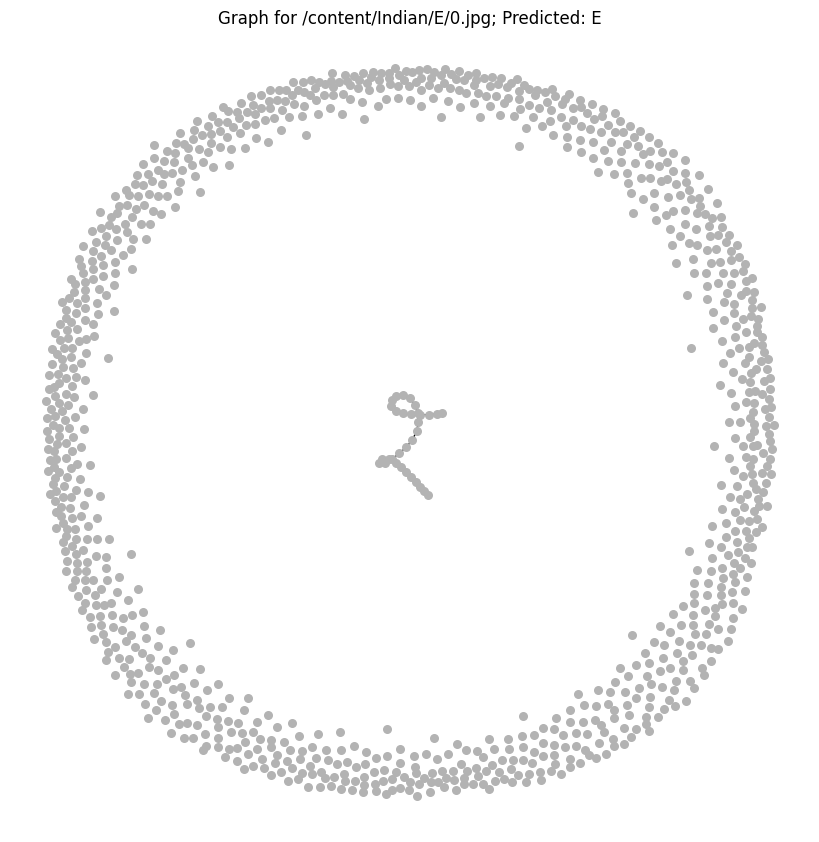

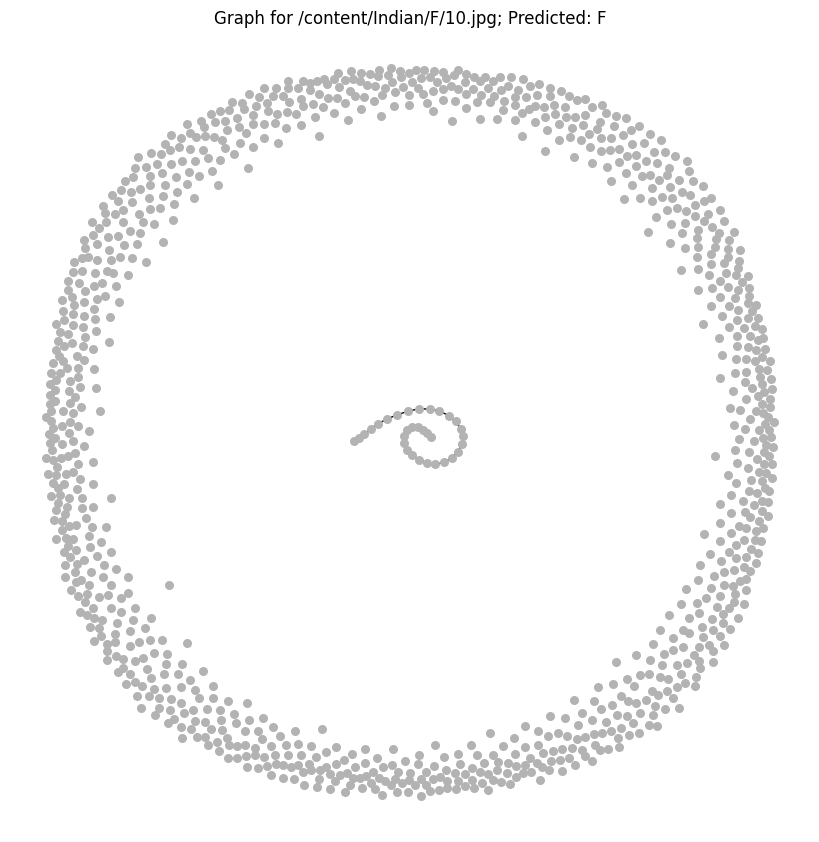

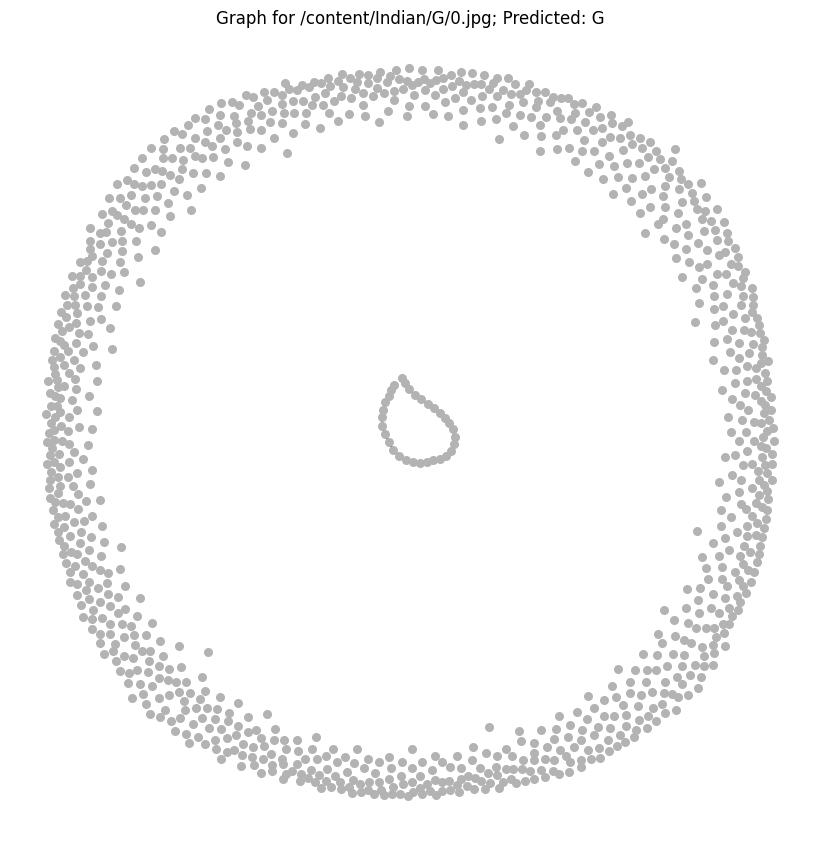

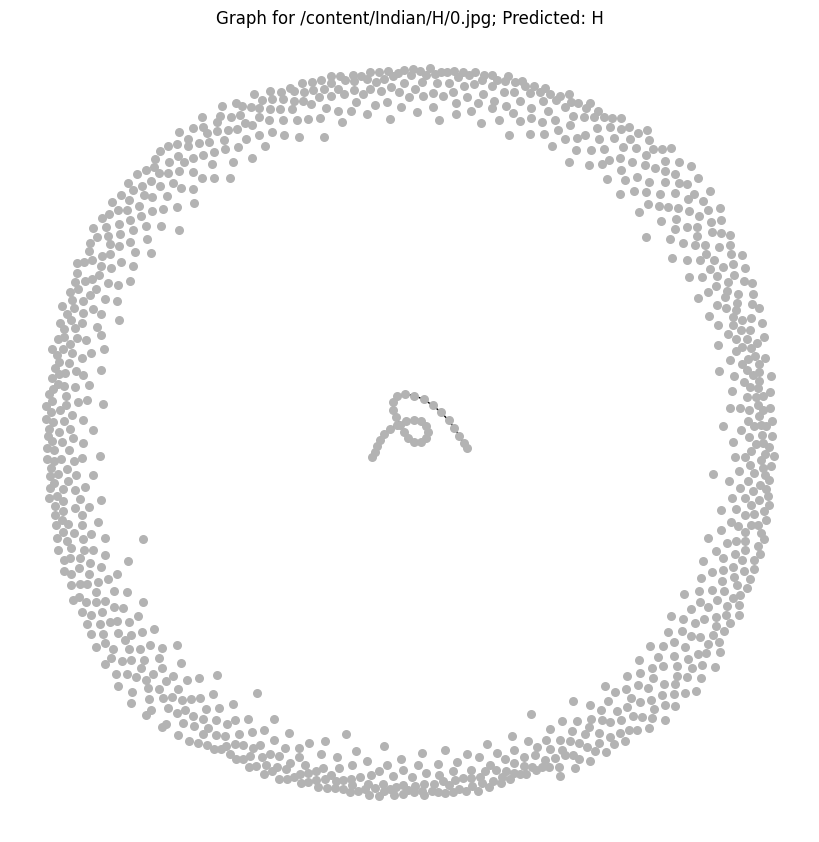

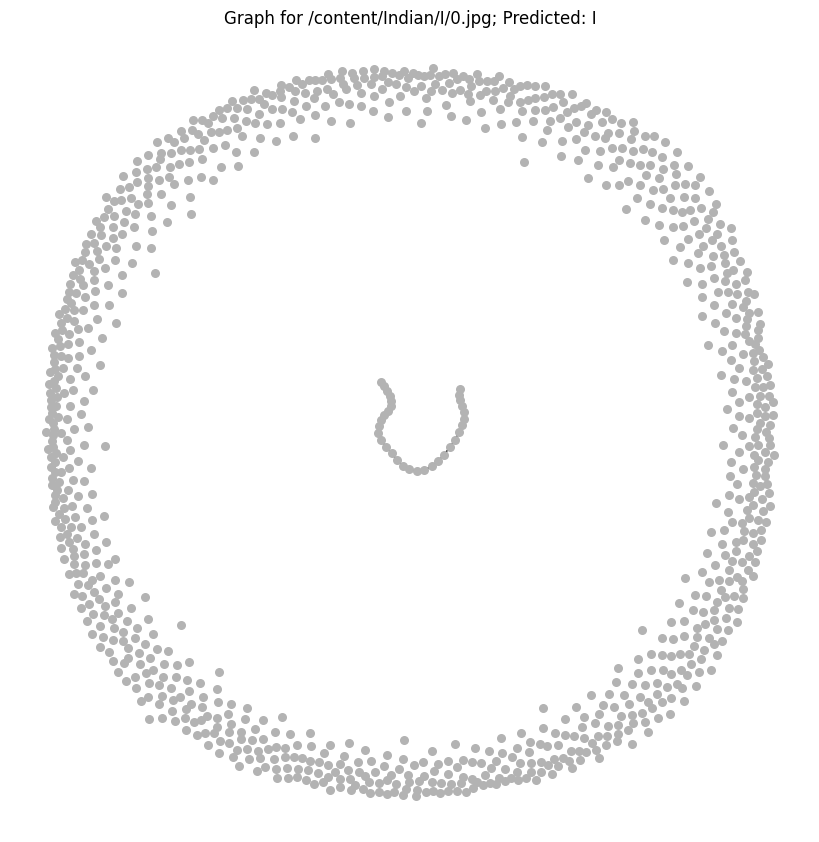

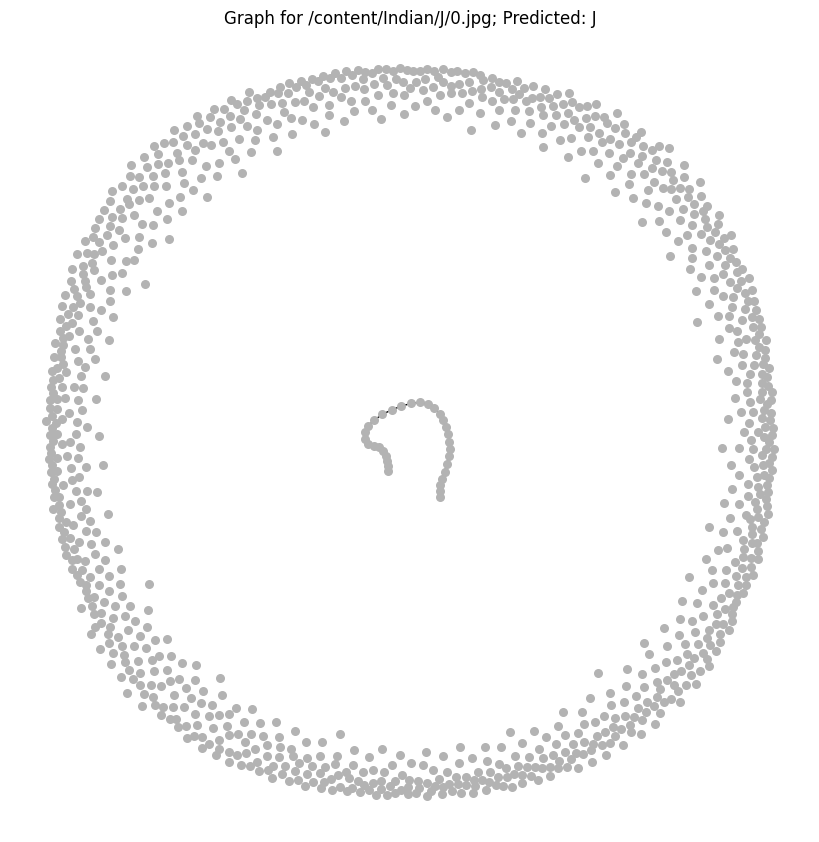

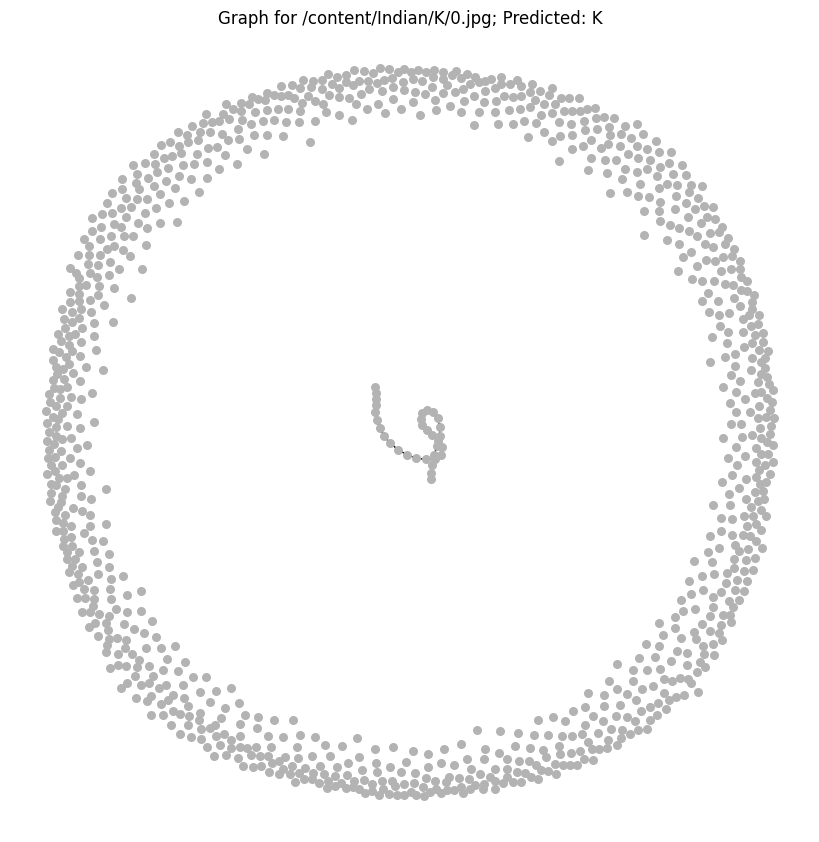

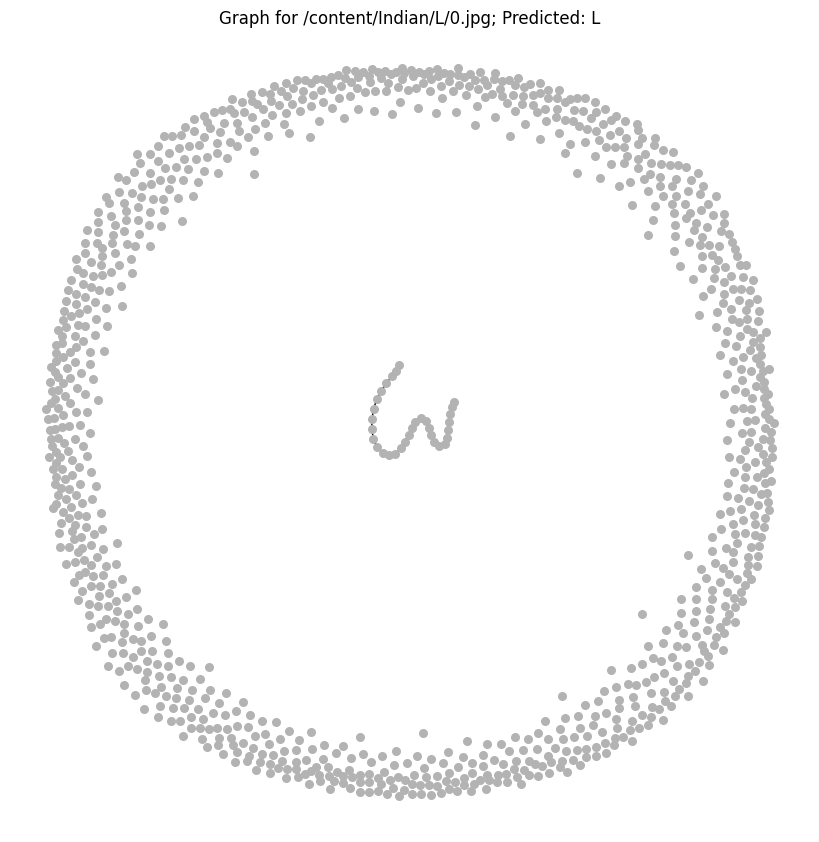

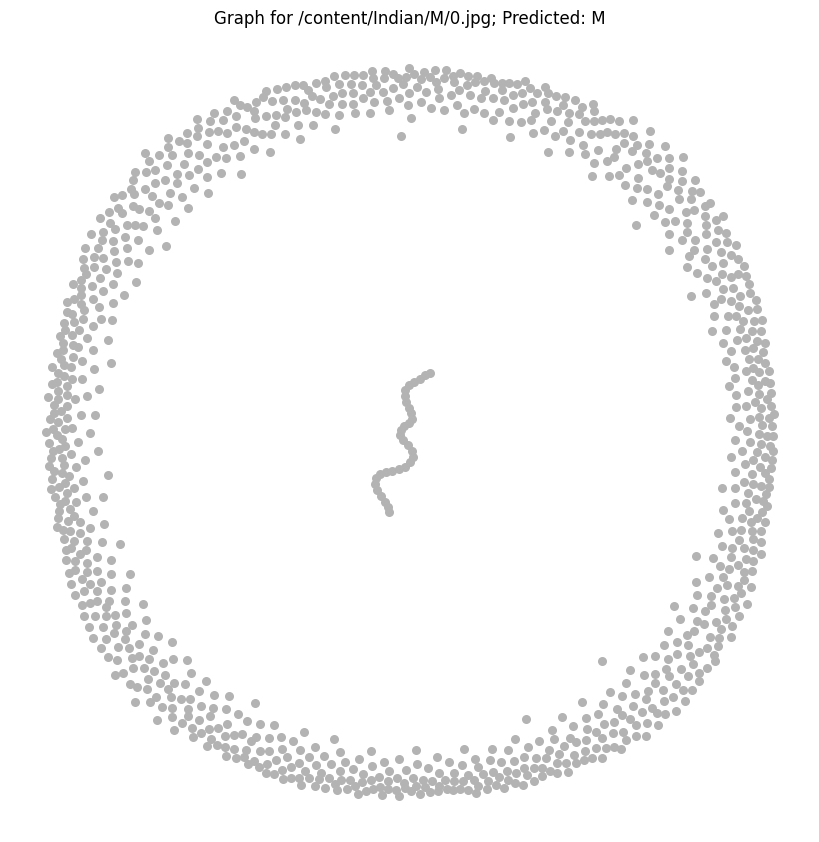

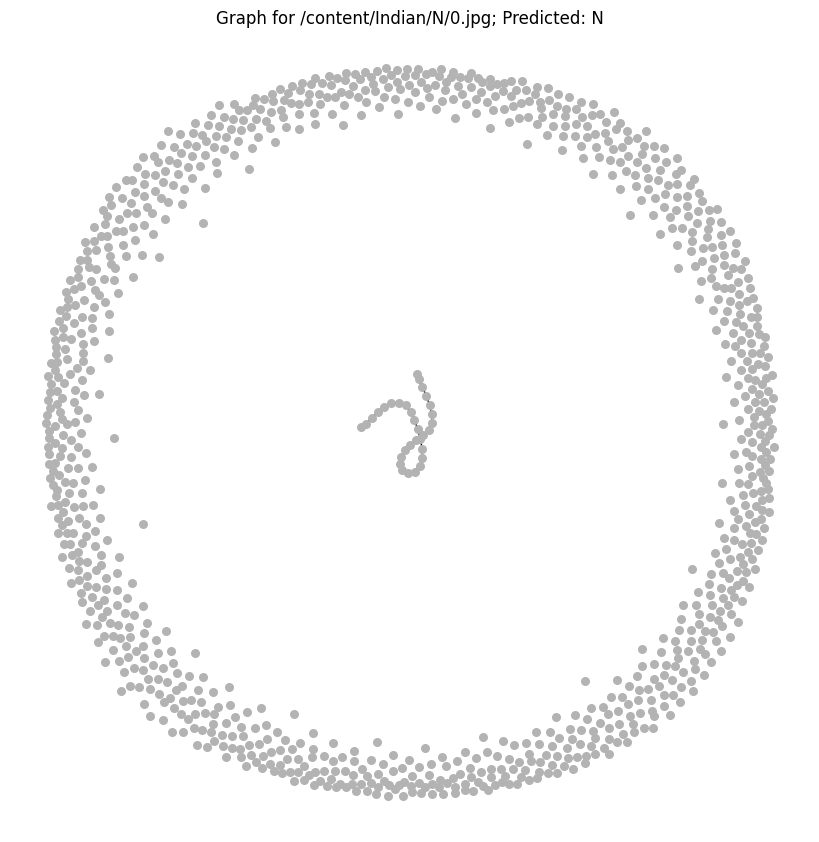

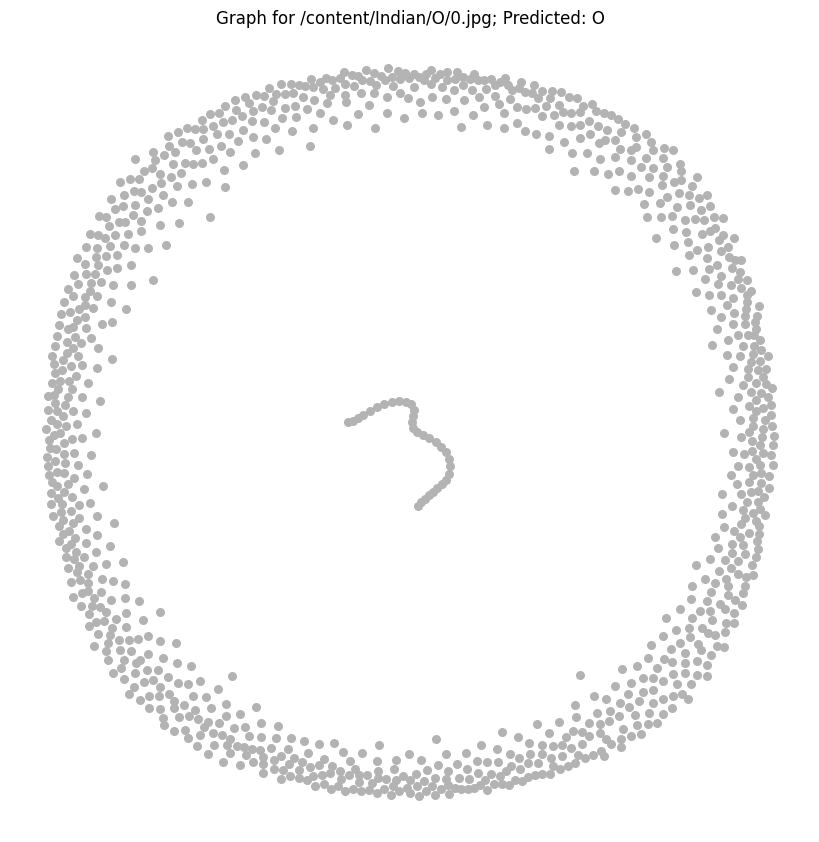

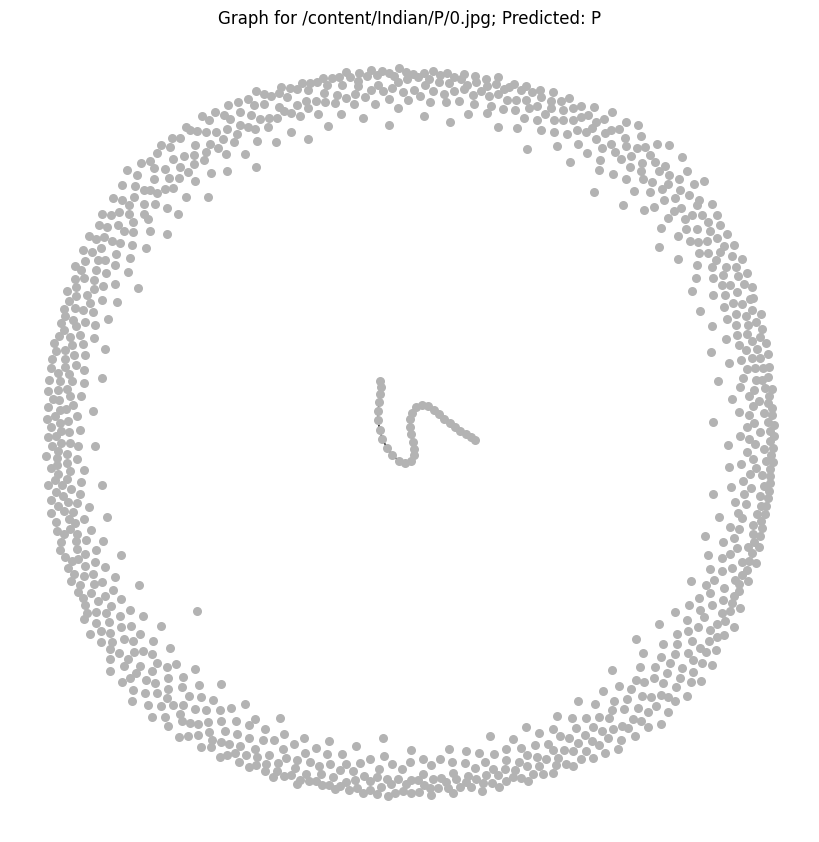

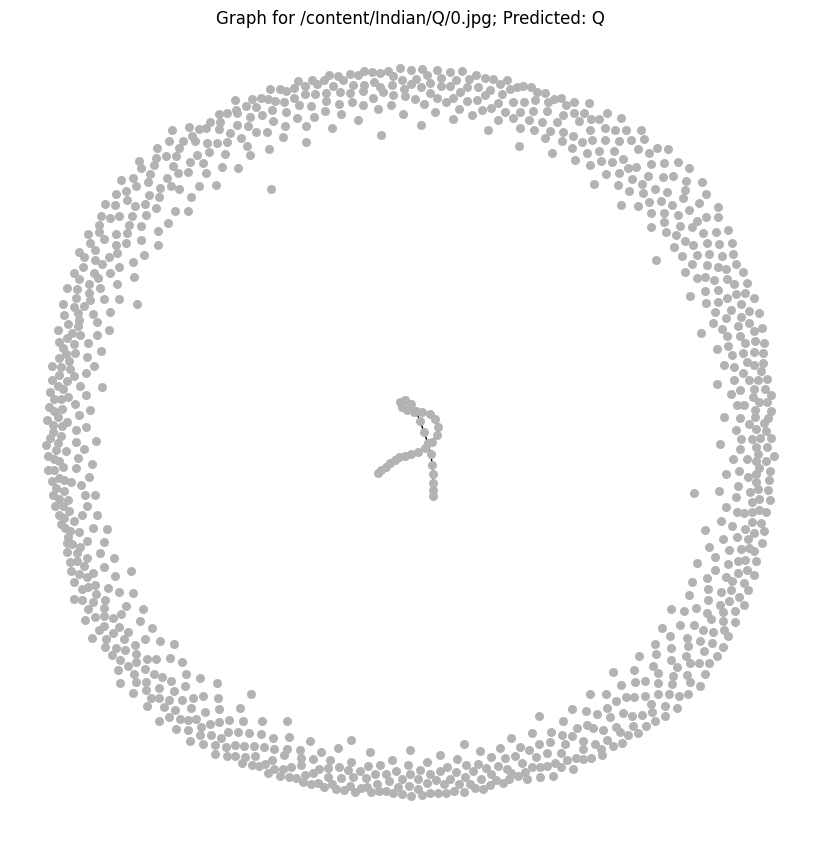

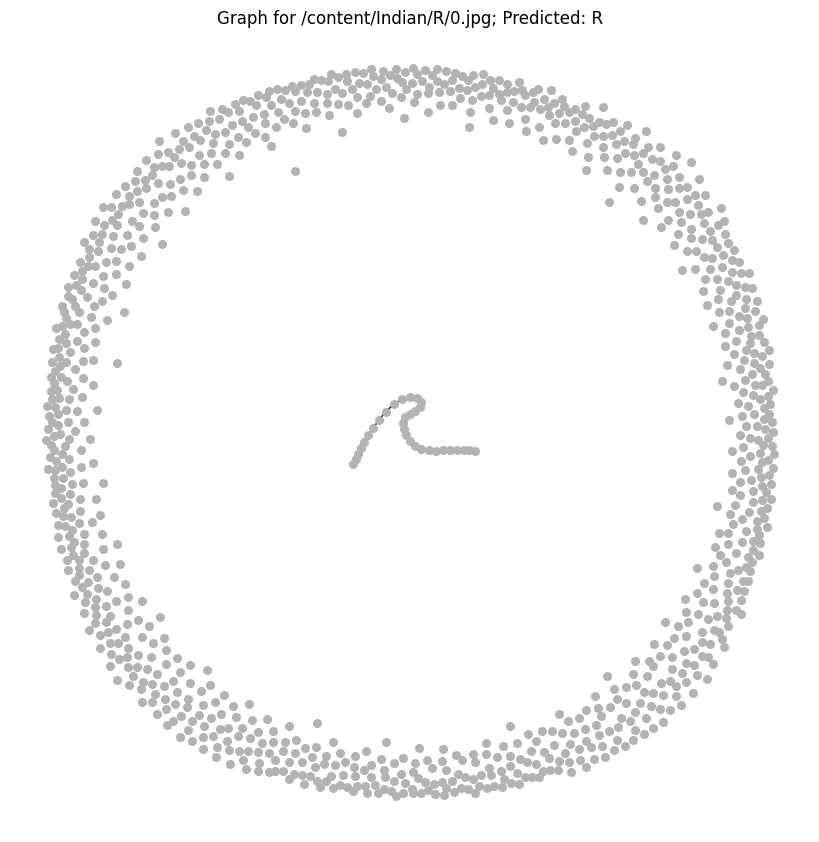

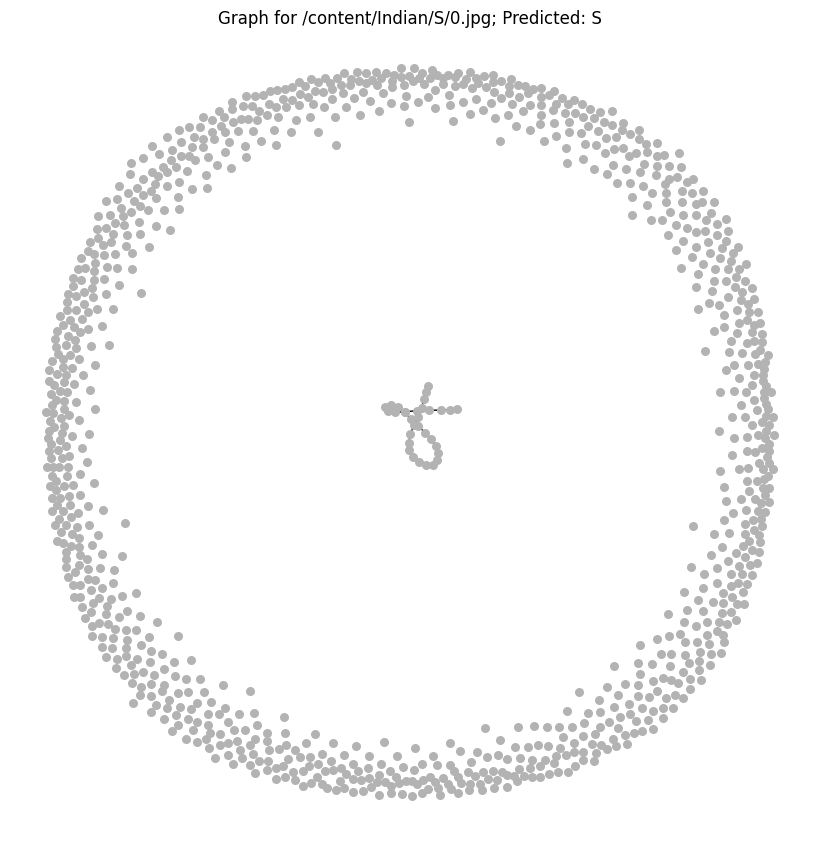

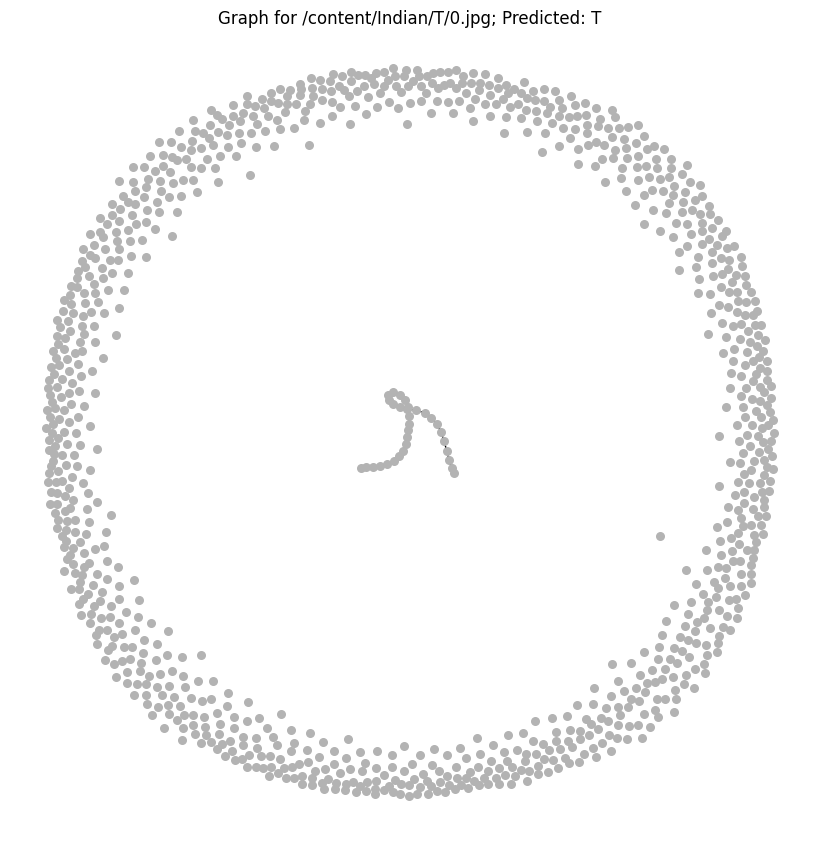

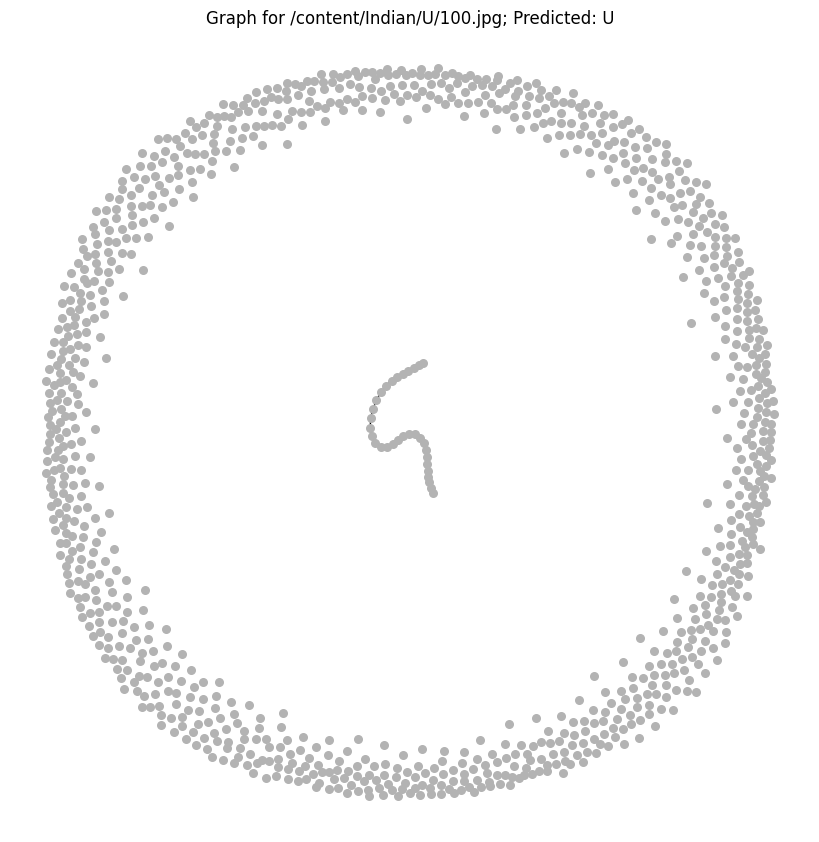

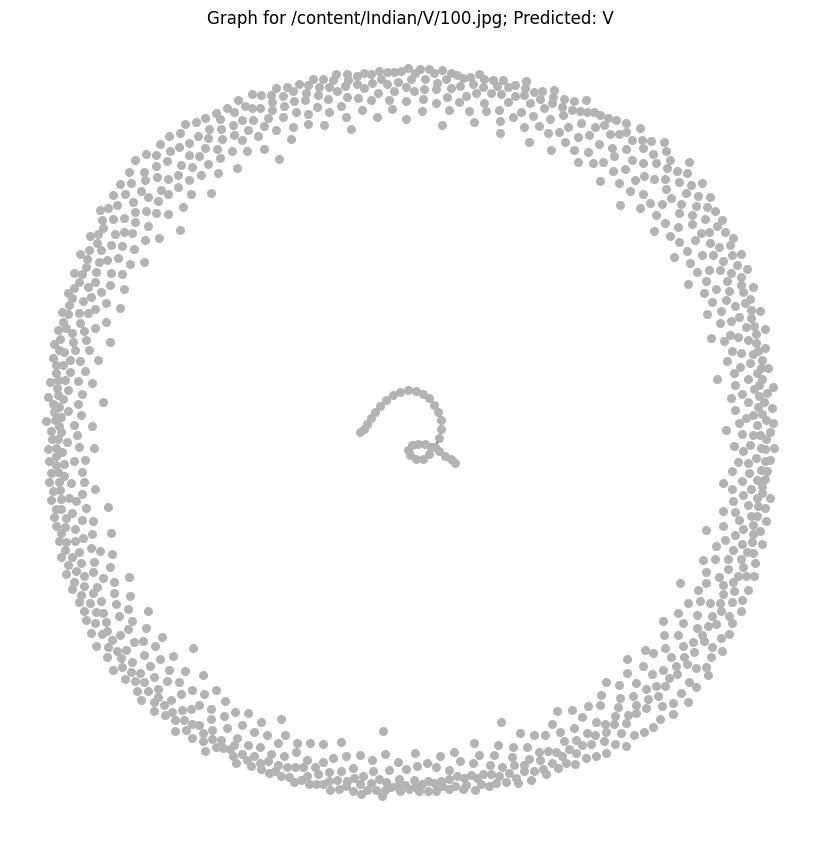

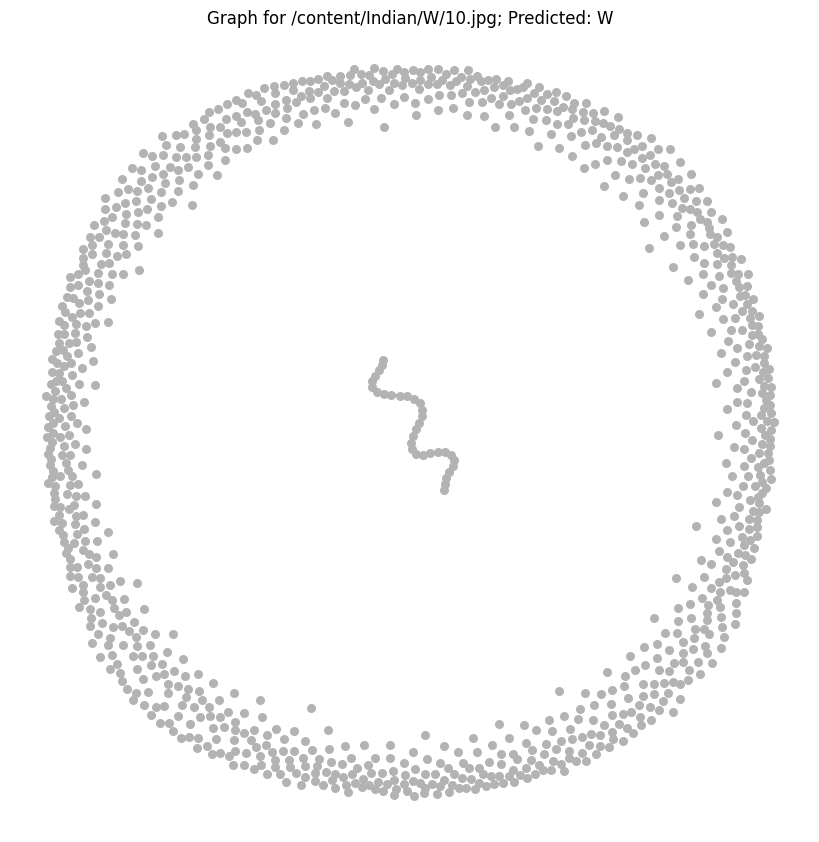

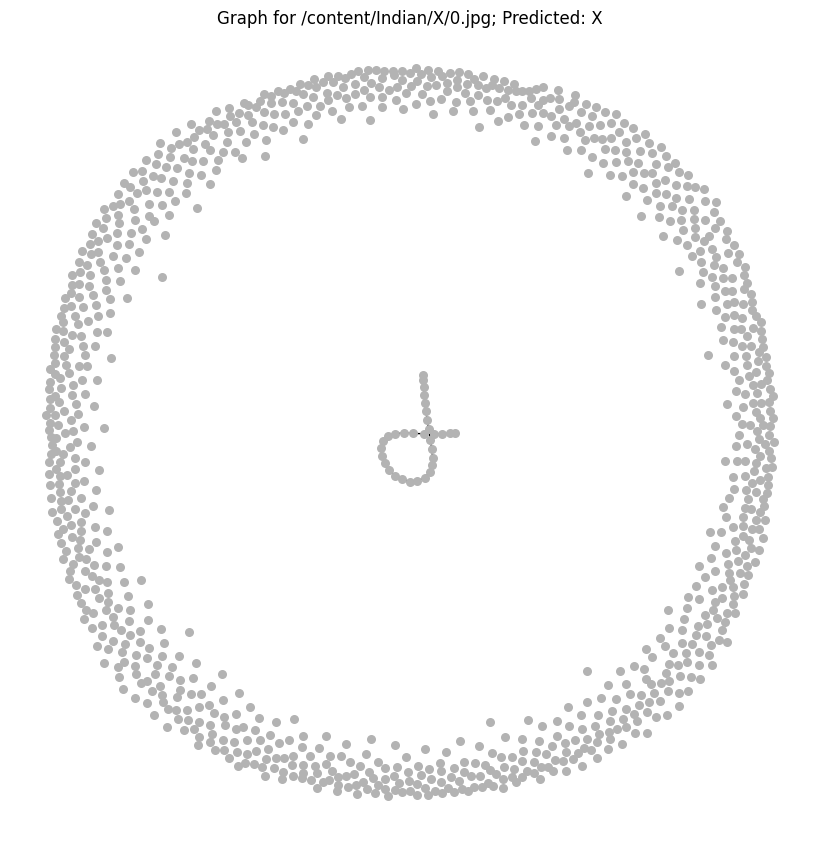

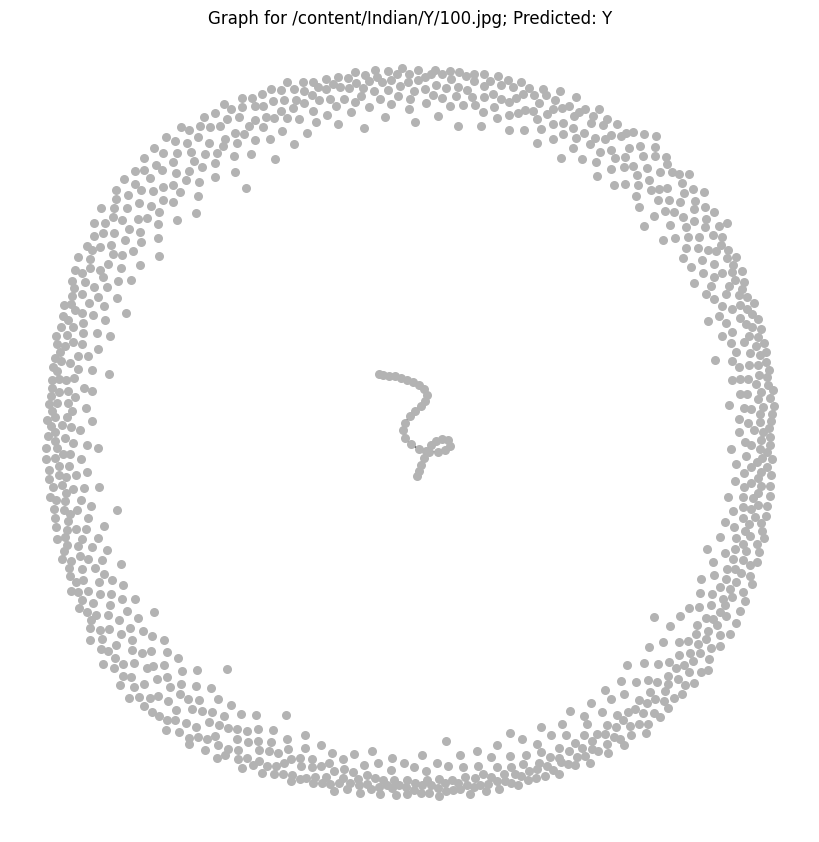

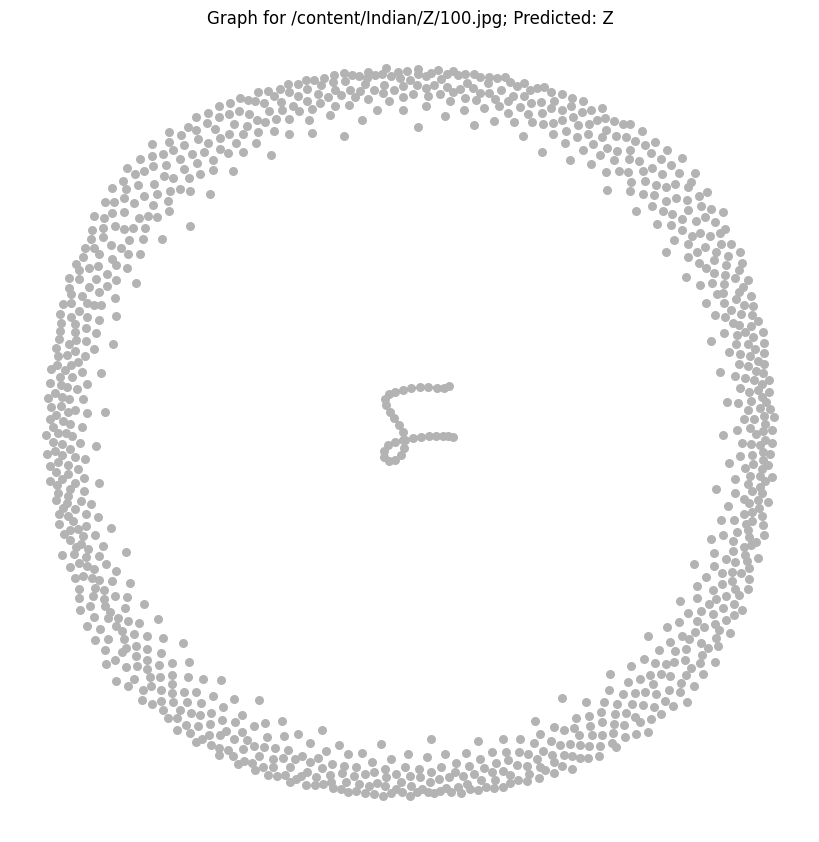

The prediction for /content/Indian/1/10.jpg is class: 1
The prediction for /content/Indian/2/0.jpg is class: 2
The prediction for /content/Indian/3/0.jpg is class: 3
The prediction for /content/Indian/4/0.jpg is class: 4
The prediction for /content/Indian/5/0.jpg is class: 5
The prediction for /content/Indian/6/0.jpg is class: 6
The prediction for /content/Indian/7/0.jpg is class: 7
The prediction for /content/Indian/8/0.jpg is class: 8
The prediction for /content/Indian/9/0.jpg is class: 9
The prediction for /content/Indian/A/0.jpg is class: A
The prediction for /content/Indian/B/0.jpg is class: B
The prediction for /content/Indian/C/10.jpg is class: C
The prediction for /content/Indian/D/0.jpg is class: D
The prediction for /content/Indian/E/0.jpg is class: E
The prediction for /content/Indian/F/10.jpg is class: F
The prediction for /content/Indian/G/0.jpg is class: G
The prediction for /content/Indian/H/0.jpg is class: H
The prediction for /content/Indian/I/0.jpg is class: I
The pre

In [28]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

def predict_and_visualize_images(image_paths, model, dataset):
    predicted_classes = []
    model.eval()  # Ensure the model is in evaluation mode

    for image_path in image_paths:
        # Predict class of the image
        predicted_index = predict_image(image_path, model)  # Assuming predict_image returns class index
        predicted_class_name = dataset.class_names[predicted_index]  # Mapping index to class

        # For visualization, reload the preprocessed image and recreate its graph
        image = cv2.imread(image_path)
        preprocessed_image = preprocess_image(image)
        graph = create_graph(preprocessed_image)

        # Visualization
        g = to_networkx(graph, to_undirected=True)
        plt.figure(figsize=(8, 8))
        nx.draw(g, node_size=30, node_color=[[0.7, 0.7, 0.7]])
        plt.title(f"Graph for {image_path}; Predicted: {predicted_class_name}")
        plt.show()

        predicted_classes.append(predicted_class_name)

    return predicted_classes

# Assuming your 'model' and 'Dataset' are correctly set up and accessible
image_paths = ["content/Indian/1/10.jpg","content/Indian/2/0.jpg","content/Indian/3/0.jpg","content/Indian/4/0.jpg","content/Indian/5/0.jpg","content/Indian/6/0.jpg","content/Indian/7/0.jpg","content/Indian/8/0.jpg","content/Indian/9/0.jpg","content/Indian/A/0.jpg","content/Indian/B/0.jpg","content/Indian/C/10.jpg","content/Indian/D/0.jpg","content/Indian/E/0.jpg","content/Indian/F/10.jpg","content/Indian/G/0.jpg","content/Indian/H/0.jpg","content/Indian/I/0.jpg","content/Indian/J/0.jpg","content/Indian/K/0.jpg","content/Indian/L/0.jpg","content/Indian/M/0.jpg","content/Indian/N/0.jpg","content/Indian/O/0.jpg","content/Indian/P/0.jpg","content/Indian/Q/0.jpg","content/Indian/R/0.jpg","content/Indian/S/0.jpg","content/Indian/T/0.jpg","content/Indian/U/100.jpg","content/Indian/V/100.jpg","content/Indian/W/10.jpg","content/Indian/X/0.jpg","content/Indian/Y/100.jpg","content/Indian/Z/100.jpg"]


predictions = predict_and_visualize_images(image_paths, model, Dataset)

for image_path, prediction in zip(image_paths, predictions):
    print(f"The prediction for {image_path} is class: {prediction}")


#files downloading

In [29]:
!zip my_files.zip /content/dataset /content/savegraphs /content/savemodels


  adding: content/dataset/ (stored 0%)
  adding: content/savegraphs/ (stored 0%)
  adding: content/savemodels/ (stored 0%)
